In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/malimg_paper_dataset_imgs"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,1)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, grayscale=True, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:       Adialer.C	Number of images: 122
Label: 1	Family:       Agent.FYI	Number of images: 116
Label: 2	Family:       Allaple.A	Number of images: 2949
Label: 3	Family:       Allaple.L	Number of images: 1591
Label: 4	Family:   Alueron.gen!J	Number of images: 198
Label: 5	Family:       Autorun.K	Number of images: 106
Label: 6	Family:     C2LOP.gen!g	Number of images: 200
Label: 7	Family:         C2LOP.P	Number of images: 146
Label: 8	Family:  Dialplatform.B	Number of images: 177
Label: 9	Family:       Dontovo.A	Number of images: 162
Label:10	Family:        Fakerean	Number of images: 381
Label:11	Family:   Instantaccess	Number of images: 431
Label:12	Family:      Lolyda.AA1	Number of images: 213
Label:13	Family:      Lolyda.AA2	Number of images: 184
Label:14	Family:      Lolyda.AA3	Number of images: 123
Label:15	Family:       Lolyda.AT	Number of images: 159
Label:16	Family:     Malex.gen!J	Number of images: 136
Label:17	Family:   Obfuscator.AD	Number of images: 142
Label:18

In [4]:
X.shape

(9339, 224, 224, 1)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [ ]:
# Training the model from scratch
num_epochs=100
image_shape = (224, 224, 1)                                                                                                                                                                                                                                                                                            
history = []
checkpointer = ModelCheckpoint(filepath='weights-malimg-grayscale-pre-xception-Adam-%depochs-fromscratch.h5' %(num_epochs), monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix

model = Xception(weights=None, input_shape=image_shape, include_top=True, classes=num_classes)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
init_weights = model.get_weights()

for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
    
    model.set_weights(init_weights)

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=32, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 8394 samples, validate on 945 samples
Epoch 1/100
8394/8394 [==============================] - 123s - loss: 0.3284 - acc: 0.9042 - val_loss: 3.6304 - val_acc: 0.0243
Epoch 2/100
8394/8394 [==============================] - 119s - loss: 0.1264 - acc: 0.9589 - val_loss: 2.1293 - val_acc: 0.5735
Epoch 3/100
8394/8394 [==============================] - 121s - loss: 0.0995 - acc: 0.9676 - val_loss: 3.3781 - val_acc: 0.6974
Epoch 4/100
8394/8394 [==============================] - 121s - loss: 0.1207 - acc: 0.9615 - val_loss: 0.5580 - val_acc: 0.7926
Epoch 5/100
8394/8394 [==============================] - 120s - loss: 0.0787 - acc: 0.9733 - val_loss: 0.1397 - val_acc: 0.9683
Epoch 6/100
8394/8394 [==============================] - 121s - loss: 0.0664 - acc: 0.9777 - val_loss: 0.1873 - val_acc: 0.9418
Epoch 7/100
8394/8394 [==============================] - 121s - loss: 0.0636 - acc: 0.9790 - val_loss: 2.0803 - val_acc: 0.6698
Epoch 8/100
8394/8394 [==============================] - 

8394/8394 [==============================] - 120s - loss: 6.8832e-06 - acc: 1.0000 - val_loss: 0.1041 - val_acc: 0.9884
Epoch 64/100
8394/8394 [==============================] - 120s - loss: 9.2843e-06 - acc: 1.0000 - val_loss: 0.1065 - val_acc: 0.9884
Epoch 65/100
8394/8394 [==============================] - 121s - loss: 7.6716e-06 - acc: 1.0000 - val_loss: 0.1072 - val_acc: 0.9884
Epoch 66/100
8394/8394 [==============================] - 121s - loss: 4.8080e-06 - acc: 1.0000 - val_loss: 0.1074 - val_acc: 0.9884
Epoch 67/100
8394/8394 [==============================] - 120s - loss: 6.2881e-06 - acc: 1.0000 - val_loss: 0.1096 - val_acc: 0.9884
Epoch 68/100
8394/8394 [==============================] - 121s - loss: 3.3408e-06 - acc: 1.0000 - val_loss: 0.1084 - val_acc: 0.9884
Epoch 69/100
8394/8394 [==============================] - 120s - loss: 3.7186e-06 - acc: 1.0000 - val_loss: 0.1097 - val_acc: 0.9873
Epoch 70/100
8394/8394 [==============================] - 120s - loss: 0.0544 - ac

8397/8397 [==============================] - 120s - loss: 0.0282 - acc: 0.9918 - val_loss: 0.5249 - val_acc: 0.8556
Epoch 25/100
8397/8397 [==============================] - 120s - loss: 0.0096 - acc: 0.9969 - val_loss: 0.0551 - val_acc: 0.9820
Epoch 26/100
8397/8397 [==============================] - 120s - loss: 0.0597 - acc: 0.9871 - val_loss: 2.4401 - val_acc: 0.5711
Epoch 27/100
8397/8397 [==============================] - 120s - loss: 0.0333 - acc: 0.9915 - val_loss: 4.0430 - val_acc: 0.6125
Epoch 28/100
8397/8397 [==============================] - 120s - loss: 0.0111 - acc: 0.9967 - val_loss: 0.0335 - val_acc: 0.9894
Epoch 29/100
8397/8397 [==============================] - 121s - loss: 0.0196 - acc: 0.9937 - val_loss: 0.0540 - val_acc: 0.9777
Epoch 30/100
8397/8397 [==============================] - 121s - loss: 0.0073 - acc: 0.9976 - val_loss: 0.0257 - val_acc: 0.9926
Epoch 31/100
8397/8397 [==============================] - 121s - loss: 0.0050 - acc: 0.9982 - val_loss: 0.0315

8397/8397 [==============================] - 120s - loss: 1.4888e-04 - acc: 1.0000 - val_loss: 0.0346 - val_acc: 0.9915
Epoch 88/100
8397/8397 [==============================] - 120s - loss: 6.2049e-05 - acc: 1.0000 - val_loss: 0.0308 - val_acc: 0.9904
Epoch 89/100
8397/8397 [==============================] - 120s - loss: 4.9974e-05 - acc: 1.0000 - val_loss: 0.0310 - val_acc: 0.9904
Epoch 90/100
8397/8397 [==============================] - 121s - loss: 2.7847e-05 - acc: 1.0000 - val_loss: 0.0371 - val_acc: 0.9926
Epoch 91/100
8397/8397 [==============================] - 121s - loss: 2.4216e-05 - acc: 1.0000 - val_loss: 0.0374 - val_acc: 0.9926
Epoch 92/100
8397/8397 [==============================] - 120s - loss: 1.3544e-05 - acc: 1.0000 - val_loss: 0.0379 - val_acc: 0.9915
Epoch 93/100
8397/8397 [==============================] - 120s - loss: 1.7183e-05 - acc: 1.0000 - val_loss: 0.0379 - val_acc: 0.9915
Epoch 94/100
8397/8397 [==============================] - 120s - loss: 0.0300 - ac

8401/8401 [==============================] - 121s - loss: 0.2170 - acc: 0.9843 - val_loss: 0.2754 - val_acc: 0.9765
Epoch 50/100
8401/8401 [==============================] - 120s - loss: 0.2132 - acc: 0.9855 - val_loss: 0.3254 - val_acc: 0.9616
Epoch 51/100
8401/8401 [==============================] - 121s - loss: 0.2110 - acc: 0.9857 - val_loss: 0.3303 - val_acc: 0.9691
Epoch 52/100
8401/8401 [==============================] - 120s - loss: 0.2103 - acc: 0.9858 - val_loss: 0.2971 - val_acc: 0.9765
Epoch 53/100
8401/8401 [==============================] - 121s - loss: 0.2087 - acc: 0.9867 - val_loss: 0.3094 - val_acc: 0.9744
Epoch 54/100
8401/8401 [==============================] - 120s - loss: 0.2181 - acc: 0.9844 - val_loss: 0.7564 - val_acc: 0.8774
Epoch 55/100
8401/8401 [==============================] - 120s - loss: 0.2230 - acc: 0.9836 - val_loss: 0.3153 - val_acc: 0.9723
Epoch 56/100
8401/8401 [==============================] - 122s - loss: 0.2171 - acc: 0.9831 - val_loss: 0.8041

8403/8403 [==============================] - 121s - loss: 0.0516 - acc: 0.9830 - val_loss: 1.0114 - val_acc: 0.8344
Epoch 12/100
8403/8403 [==============================] - 121s - loss: 0.0325 - acc: 0.9893 - val_loss: 0.0993 - val_acc: 0.9605
Epoch 13/100
8403/8403 [==============================] - 120s - loss: 0.0296 - acc: 0.9912 - val_loss: 0.0663 - val_acc: 0.9808
Epoch 14/100
8403/8403 [==============================] - 120s - loss: 0.0264 - acc: 0.9920 - val_loss: 0.1056 - val_acc: 0.9605
Epoch 15/100
8403/8403 [==============================] - 121s - loss: 0.0255 - acc: 0.9921 - val_loss: 7.1357 - val_acc: 0.3387
Epoch 16/100
8403/8403 [==============================] - 121s - loss: 0.0186 - acc: 0.9939 - val_loss: 0.0936 - val_acc: 0.9754
Epoch 17/100
8403/8403 [==============================] - 121s - loss: 0.0229 - acc: 0.9931 - val_loss: 1.1559 - val_acc: 0.7511
Epoch 18/100
8403/8403 [==============================] - 121s - loss: 0.0459 - acc: 0.9880 - val_loss: 0.0691

8403/8403 [==============================] - 121s - loss: 0.0021 - acc: 0.9999 - val_loss: 0.0661 - val_acc: 0.9915
Epoch 75/100
8403/8403 [==============================] - 122s - loss: 0.0019 - acc: 0.9999 - val_loss: 0.0655 - val_acc: 0.9904
Epoch 76/100
8403/8403 [==============================] - 120s - loss: 0.0019 - acc: 0.9999 - val_loss: 0.0654 - val_acc: 0.9925
Epoch 77/100
8403/8403 [==============================] - 121s - loss: 0.0019 - acc: 0.9999 - val_loss: 0.0655 - val_acc: 0.9915
Epoch 78/100
8403/8403 [==============================] - 121s - loss: 0.0019 - acc: 0.9999 - val_loss: 0.0666 - val_acc: 0.9904
Epoch 79/100
8403/8403 [==============================] - 120s - loss: 0.0019 - acc: 0.9999 - val_loss: 0.0664 - val_acc: 0.9915
Epoch 80/100
8403/8403 [==============================] - 121s - loss: 0.0019 - acc: 0.9999 - val_loss: 0.0663 - val_acc: 0.9915
Epoch 81/100
8403/8403 [==============================] - 120s - loss: 0.0020 - acc: 0.9999 - val_loss: 0.0685

8404/8404 [==============================] - 121s - loss: 0.0080 - acc: 0.9975 - val_loss: 0.0510 - val_acc: 0.9840
Epoch 37/100
8404/8404 [==============================] - 121s - loss: 0.0142 - acc: 0.9954 - val_loss: 0.0355 - val_acc: 0.9882
Epoch 38/100
8404/8404 [==============================] - 121s - loss: 0.0097 - acc: 0.9968 - val_loss: 0.0571 - val_acc: 0.9850
Epoch 39/100
8404/8404 [==============================] - 121s - loss: 0.0031 - acc: 0.9992 - val_loss: 0.0592 - val_acc: 0.9904
Epoch 40/100
8404/8404 [==============================] - 120s - loss: 0.0057 - acc: 0.9981 - val_loss: 0.0531 - val_acc: 0.9882
Epoch 41/100
8404/8404 [==============================] - 121s - loss: 0.0058 - acc: 0.9981 - val_loss: 0.0484 - val_acc: 0.9882
Epoch 42/100
8404/8404 [==============================] - 120s - loss: 4.8782e-04 - acc: 1.0000 - val_loss: 0.0536 - val_acc: 0.9904
Epoch 43/100
8404/8404 [==============================] - 121s - loss: 6.1333e-04 - acc: 0.9999 - val_loss

8404/8404 [==============================] - 121s - loss: 0.0036 - acc: 0.9987 - val_loss: 0.0892 - val_acc: 0.9872
Epoch 99/100
8404/8404 [==============================] - 121s - loss: 5.2581e-04 - acc: 0.9999 - val_loss: 0.0854 - val_acc: 0.9904
Epoch 100/100
928/935 [============================>.] - ETA: 0s[4] Test acurracy: 0.9904 (12120.1994 s)
Train on 8404 samples, validate on 935 samples
Epoch 1/100
8404/8404 [==============================] - 121s - loss: 1.9585 - acc: 0.6216 - val_loss: 3.3132 - val_acc: 0.4267
Epoch 2/100
8404/8404 [==============================] - 120s - loss: 0.9085 - acc: 0.8138 - val_loss: 4.3264 - val_acc: 0.4856
Epoch 3/100
8404/8404 [==============================] - 120s - loss: 0.2615 - acc: 0.9199 - val_loss: 0.2130 - val_acc: 0.9540
Epoch 4/100
8404/8404 [==============================] - 121s - loss: 0.1694 - acc: 0.9454 - val_loss: 0.1382 - val_acc: 0.9615
Epoch 5/100
8404/8404 [==============================] - 121s - loss: 0.1418 - acc: 0.9

8404/8404 [==============================] - 120s - loss: 0.0016 - acc: 0.9995 - val_loss: 0.0406 - val_acc: 0.9925
Epoch 61/100
8404/8404 [==============================] - 121s - loss: 2.5030e-04 - acc: 1.0000 - val_loss: 0.0395 - val_acc: 0.9925
Epoch 62/100
8404/8404 [==============================] - 120s - loss: 1.2349e-04 - acc: 1.0000 - val_loss: 0.0364 - val_acc: 0.9925
Epoch 63/100
8404/8404 [==============================] - 121s - loss: 0.0019 - acc: 0.9995 - val_loss: 0.0510 - val_acc: 0.9914
Epoch 64/100
8404/8404 [==============================] - 121s - loss: 0.0058 - acc: 0.9980 - val_loss: 0.1636 - val_acc: 0.9765
Epoch 65/100
8404/8404 [==============================] - 121s - loss: 0.0084 - acc: 0.9981 - val_loss: 0.0695 - val_acc: 0.9893
Epoch 66/100
8404/8404 [==============================] - 120s - loss: 0.0034 - acc: 0.9987 - val_loss: 0.0637 - val_acc: 0.9925
Epoch 67/100
8404/8404 [==============================] - 120s - loss: 0.0012 - acc: 0.9999 - val_loss

8408/8408 [==============================] - 120s - loss: 0.0597 - acc: 0.9789 - val_loss: 0.0704 - val_acc: 0.9796
Epoch 23/100
8408/8408 [==============================] - 121s - loss: 0.0483 - acc: 0.9845 - val_loss: 0.1008 - val_acc: 0.9689
Epoch 24/100
8408/8408 [==============================] - 121s - loss: 0.0453 - acc: 0.9856 - val_loss: 0.0845 - val_acc: 0.9764
Epoch 25/100
8408/8408 [==============================] - 120s - loss: 0.0512 - acc: 0.9835 - val_loss: 0.4100 - val_acc: 0.8679
Epoch 26/100
8408/8408 [==============================] - 121s - loss: 0.0814 - acc: 0.9740 - val_loss: 0.0706 - val_acc: 0.9839
Epoch 27/100
8408/8408 [==============================] - 120s - loss: 0.0499 - acc: 0.9845 - val_loss: 0.0856 - val_acc: 0.9742
Epoch 28/100
8408/8408 [==============================] - 120s - loss: 0.0450 - acc: 0.9855 - val_loss: 0.2455 - val_acc: 0.9452
Epoch 29/100
8408/8408 [==============================] - 120s - loss: 0.0513 - acc: 0.9837 - val_loss: 0.0794

8408/8408 [==============================] - 121s - loss: 0.0014 - acc: 0.9995 - val_loss: 0.0444 - val_acc: 0.9914
Epoch 97/100
8408/8408 [==============================] - 120s - loss: 2.8225e-04 - acc: 1.0000 - val_loss: 0.0412 - val_acc: 0.9925
Epoch 98/100
8408/8408 [==============================] - 121s - loss: 2.7205e-04 - acc: 0.9999 - val_loss: 0.0423 - val_acc: 0.9925
Epoch 99/100
8408/8408 [==============================] - 121s - loss: 0.0019 - acc: 0.9992 - val_loss: 0.0513 - val_acc: 0.9903
Epoch 100/100
928/931 [============================>.] - ETA: 0s[6] Test acurracy: 0.9903 (12097.4726 s)
Train on 8410 samples, validate on 929 samples
Epoch 1/100
8410/8410 [==============================] - 121s - loss: 1.6018 - acc: 0.6696 - val_loss: 10.9999 - val_acc: 0.3175
Epoch 2/100
8410/8410 [==============================] - 120s - loss: 0.6360 - acc: 0.8572 - val_loss: 0.5486 - val_acc: 0.8784
Epoch 3/100
8410/8410 [==============================] - 121s - loss: 0.4104 - a

8410/8410 [==============================] - 121s - loss: 0.0036 - acc: 0.9995 - val_loss: 0.0305 - val_acc: 0.9903
Epoch 59/100
8410/8410 [==============================] - 120s - loss: 0.0090 - acc: 0.9975 - val_loss: 6.3028 - val_acc: 0.5145
Epoch 60/100
8410/8410 [==============================] - 120s - loss: 0.0040 - acc: 0.9992 - val_loss: 0.0784 - val_acc: 0.9817
Epoch 61/100
8410/8410 [==============================] - 120s - loss: 0.0536 - acc: 0.9956 - val_loss: 0.7505 - val_acc: 0.8439
Epoch 62/100
8410/8410 [==============================] - 121s - loss: 0.0057 - acc: 0.9987 - val_loss: 0.0366 - val_acc: 0.9903
Epoch 63/100
8410/8410 [==============================] - 121s - loss: 0.0060 - acc: 0.9987 - val_loss: 0.0482 - val_acc: 0.9914
Epoch 64/100
8410/8410 [==============================] - 121s - loss: 0.0023 - acc: 0.9999 - val_loss: 0.0331 - val_acc: 0.9925
Epoch 65/100
8410/8410 [==============================] - 120s - loss: 0.0059 - acc: 0.9986 - val_loss: 0.0613

8416/8416 [==============================] - 121s - loss: 0.0051 - acc: 0.9982 - val_loss: 0.0384 - val_acc: 0.9881
Epoch 42/100
8416/8416 [==============================] - 121s - loss: 0.0021 - acc: 0.9993 - val_loss: 0.0307 - val_acc: 0.9935
Epoch 43/100
8416/8416 [==============================] - 120s - loss: 0.0081 - acc: 0.9981 - val_loss: 0.0365 - val_acc: 0.9946
Epoch 44/100
8416/8416 [==============================] - 120s - loss: 0.0052 - acc: 0.9985 - val_loss: 0.0776 - val_acc: 0.9794
Epoch 45/100
8416/8416 [==============================] - 120s - loss: 0.0033 - acc: 0.9986 - val_loss: 0.0335 - val_acc: 0.9902
Epoch 46/100
8416/8416 [==============================] - 120s - loss: 0.0132 - acc: 0.9966 - val_loss: 2.3793 - val_acc: 0.7443
Epoch 47/100
8416/8416 [==============================] - 121s - loss: 0.2038 - acc: 0.9832 - val_loss: 0.2184 - val_acc: 0.9772
Epoch 48/100
8416/8416 [==============================] - 120s - loss: 0.2013 - acc: 0.9813 - val_loss: 0.2547

In [8]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9321


In [9]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

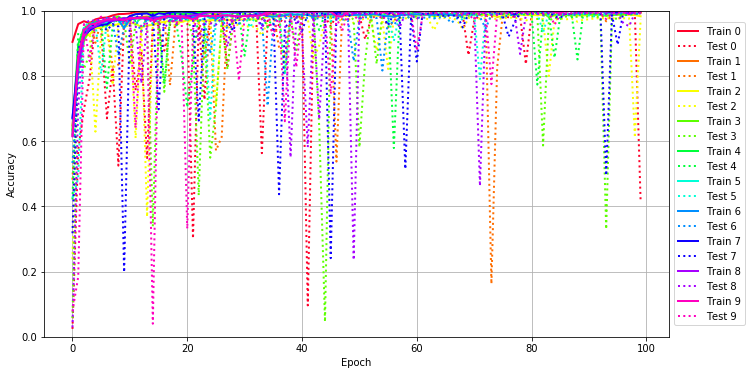

In [10]:
plot_acc(history)

In [11]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

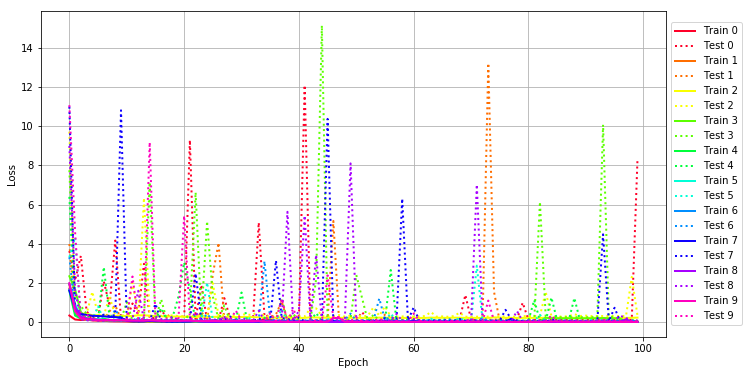

In [12]:
plot_loss(history)

Plotting the confusion matrix


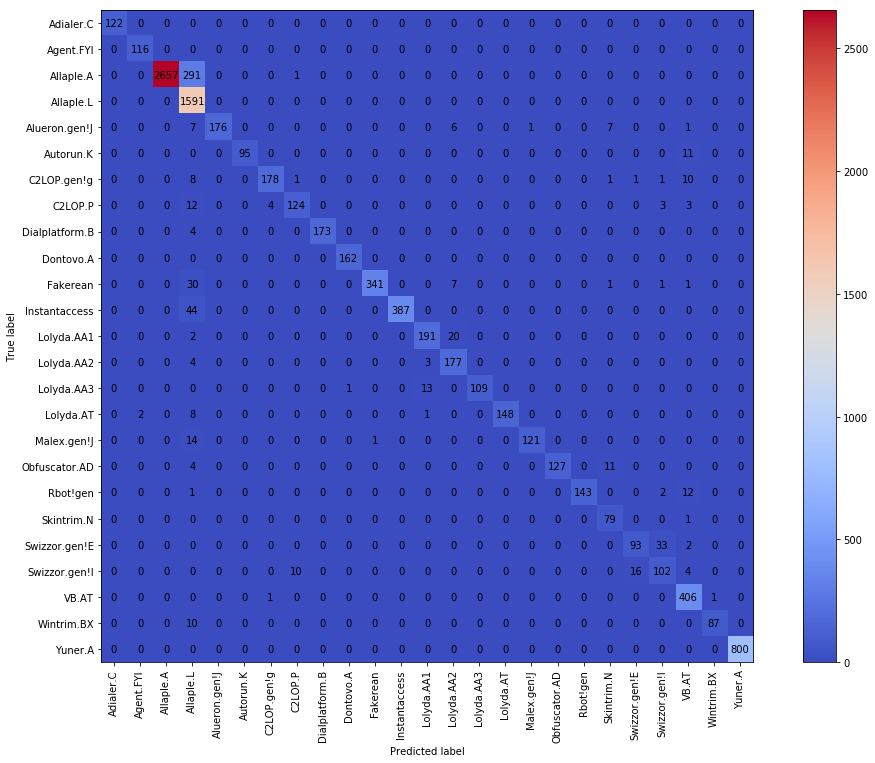

In [13]:
print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(18, 12)
plt.imshow(conf_mat,interpolation='nearest',cmap='coolwarm')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(int(conf_mat[row][col])),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

Plotting the confusion matrix normalized


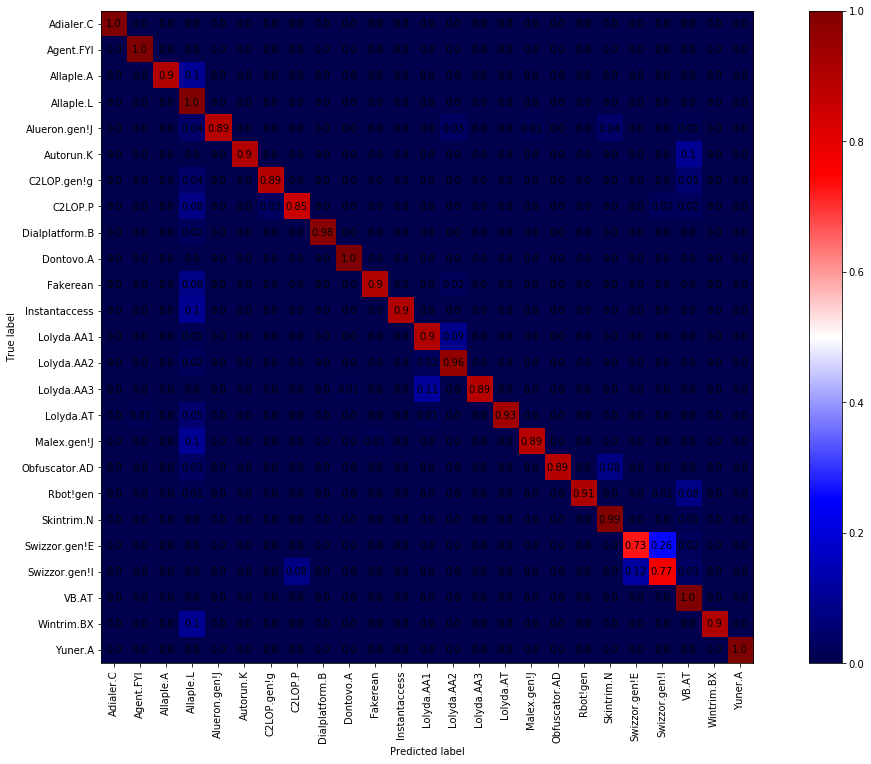

In [14]:
print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1,keepdims=True)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(20, 12)
plt.imshow(conf_mat_norm,interpolation='nearest',cmap='seismic')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat_norm[row][col]),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

Plotting the confusion matrix normalized


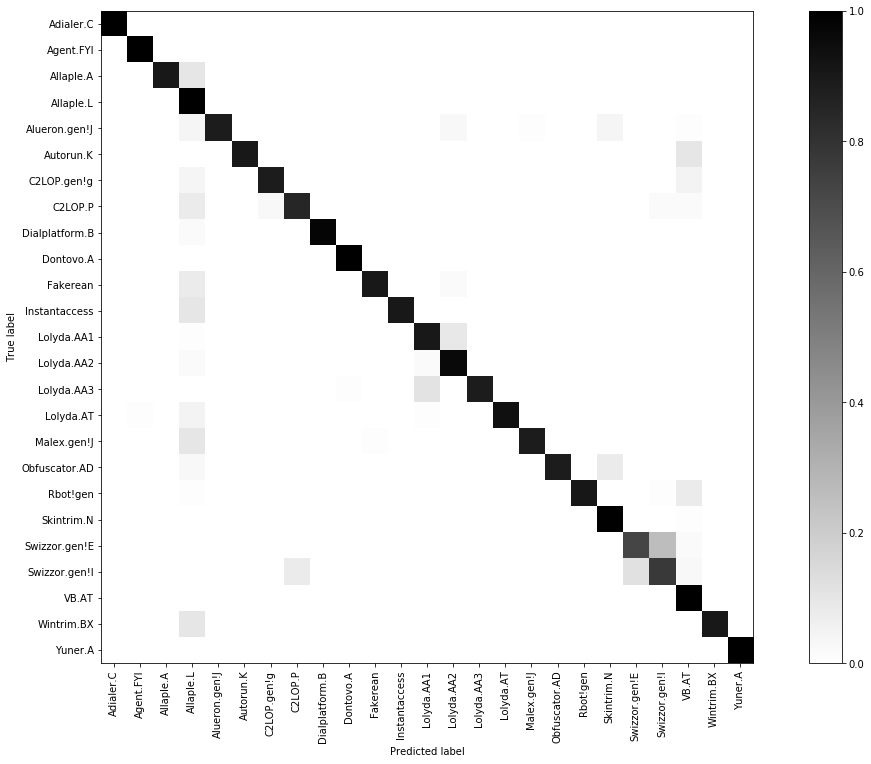

In [15]:
print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1,keepdims=True)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(20, 12)
plt.imshow(conf_mat_norm,interpolation='nearest',cmap='binary')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

Plotting the confusion matrix normalized


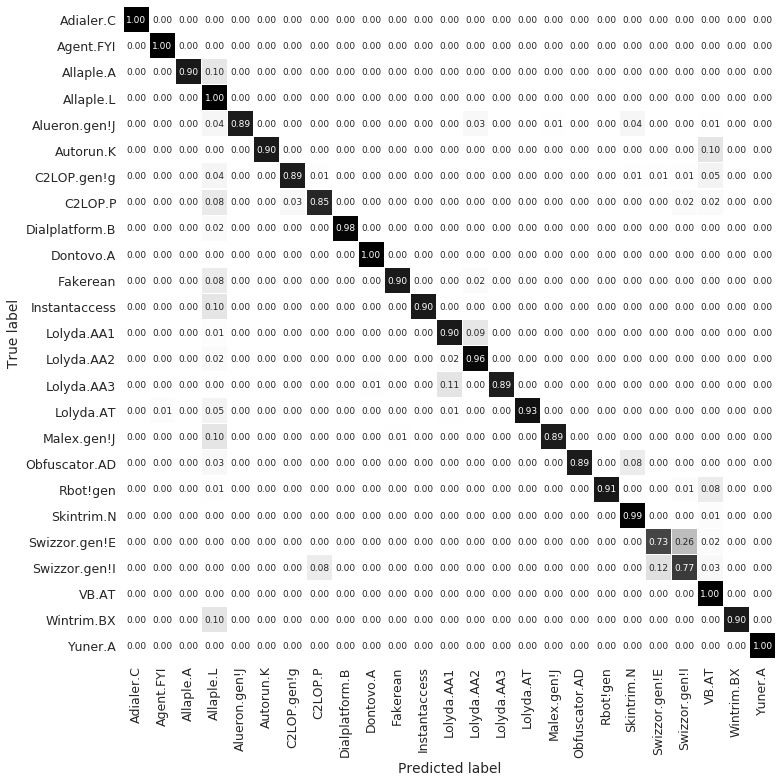

In [16]:
import seaborn as sns

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1,keepdims=True)  # Normalizing the confusion matrix

figure = plt.gcf()
figure.set_size_inches(20, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 9}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [17]:
for h in history:
    print(h.history)

{'val_loss': [3.6303722099021627, 2.1293411007633916, 3.3780937466671901, 0.5579643720130204, 0.13968193541039473, 0.18729943895944093, 2.0802591651361708, 0.81811807690226479, 4.1613313427677863, 0.14346403355473683, 0.14050861321671504, 0.94501521249279541, 0.38041743866695221, 2.9706758485939453, 0.18143181659856844, 0.21037217536619335, 0.60903137981615685, 0.21728692169828848, 0.20328988719128135, 0.1224591671472344, 0.10092869286014024, 9.2919925608962934, 0.14547734859691772, 1.8883315049602174, 0.079396050407385746, 0.09029536138359473, 0.085134525458268648, 1.220625852736297, 0.1960274989256964, 0.097808173558832867, 0.078525524071203903, 0.080726961630905578, 0.086975186121006895, 5.0800499843739013, 0.27955066961635855, 0.3556975656694773, 0.20486286747352492, 0.096737332816465363, 0.13561475869073861, 0.10491897237693545, 0.10619367768420601, 12.098745614510996, 0.11325090996377656, 0.091016288545194973, 0.091700462831630455, 0.25558777362670387, 0.074041419696541183, 0.071

In [18]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

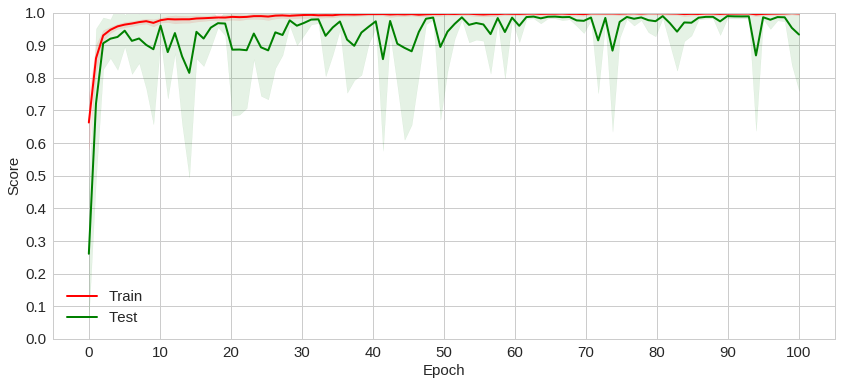

In [19]:
plot_mean_acc(history)

In [20]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

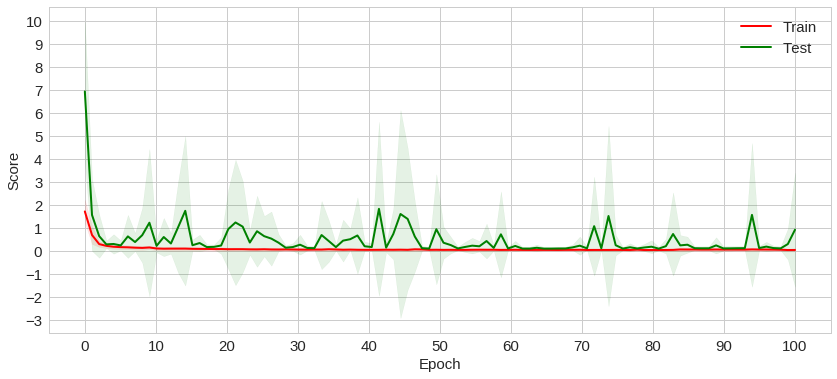

In [21]:
plot_mean_loss(history)

In [22]:
hist = [{'val_loss': [3.6303722099021627, 2.1293411007633916, 3.3780937466671901, 0.5579643720130204, 0.13968193541039473, 0.18729943895944093, 2.0802591651361708, 0.81811807690226479, 4.1613313427677863, 0.14346403355473683, 0.14050861321671504, 0.94501521249279541, 0.38041743866695221, 2.9706758485939453, 0.18143181659856844, 0.21037217536619335, 0.60903137981615685, 0.21728692169828848, 0.20328988719128135, 0.1224591671472344, 0.10092869286014024, 9.2919925608962934, 0.14547734859691772, 1.8883315049602174, 0.079396050407385746, 0.09029536138359473, 0.085134525458268648, 1.220625852736297, 0.1960274989256964, 0.097808173558832867, 0.078525524071203903, 0.080726961630905578, 0.086975186121006895, 5.0800499843739013, 0.27955066961635855, 0.3556975656694773, 0.20486286747352492, 0.096737332816465363, 0.13561475869073861, 0.10491897237693545, 0.10619367768420601, 12.098745614510996, 0.11325090996377656, 0.091016288545194973, 0.091700462831630455, 0.25558777362670387, 0.074041419696541183, 0.071989190898580954, 0.073788463197255127, 0.07468418391339772, 0.080260138182923657, 0.50353485340350446, 0.13286675273174395, 0.099262510597079925, 0.10248078197371524, 0.10033997609510095, 0.10141466408577156, 0.10212653578316264, 0.10138589942229177, 0.10222069181937832, 0.0987389715527279, 0.10324677997641414, 0.10413071890832068, 0.10653382069063672, 0.10717076788111445, 0.10738087345369679, 0.10960636181886489, 0.10835983510372126, 0.10969434084874675, 1.380447984624797, 0.12562503603031119, 0.088102014704114384, 0.089551213371781194, 0.11838327788659676, 0.12270264733619593, 0.12197304524197897, 0.12228930794261433, 0.12002606707938561, 0.14317968690403277, 0.98382862654418335, 0.089388461067877525, 0.09998595362435482, 0.099877113657534489, 0.10128006829955312, 0.11088892677590576, 0.1138776889851997, 0.11528620298995257, 0.11620406001717616, 0.1176940666026276, 0.11587155453520942, 0.11344600613832445, 0.11418265025162468, 0.11394429253866976, 0.11400047327240218, 0.11669831648353168, 0.11562656342165005, 0.11642599517107624, 0.11687419456160421, 0.11770113038431135, 8.3378266918342359], 'val_acc': [0.02433862433862434, 0.57354497354497358, 0.69735449735449739, 0.79259259259259263, 0.96825396825396826, 0.94179894179894175, 0.66984126984126979, 0.82645502645502644, 0.52486772486772482, 0.97037037037037033, 0.97460317460317458, 0.75555555555555554, 0.87513227513227509, 0.54814814814814816, 0.96825396825396826, 0.95343915343915342, 0.87724867724867728, 0.95767195767195767, 0.94814814814814818, 0.97989417989417993, 0.982010582010582, 0.30158730158730157, 0.97037037037037033, 0.72698412698412695, 0.98412698412698407, 0.98412698412698407, 0.98412698412698407, 0.82433862433862437, 0.96719576719576716, 0.97883597883597884, 0.98518518518518516, 0.98518518518518516, 0.98518518518518516, 0.562962962962963, 0.96931216931216935, 0.92592592592592593, 0.95767195767195767, 0.98624338624338626, 0.982010582010582, 0.982010582010582, 0.98306878306878309, 0.096296296296296297, 0.98518518518518516, 0.98306878306878309, 0.98095238095238091, 0.95238095238095233, 0.98518518518518516, 0.98624338624338626, 0.98518518518518516, 0.98624338624338626, 0.98518518518518516, 0.91216931216931219, 0.97460317460317458, 0.98624338624338626, 0.98730158730158735, 0.98730158730158735, 0.98941798941798942, 0.98835978835978833, 0.98835978835978833, 0.98835978835978833, 0.98730158730158735, 0.98835978835978833, 0.98835978835978833, 0.98835978835978833, 0.98835978835978833, 0.98835978835978833, 0.98835978835978833, 0.98835978835978833, 0.98730158730158735, 0.86349206349206353, 0.97037037037037033, 0.98624338624338626, 0.98412698412698407, 0.982010582010582, 0.98095238095238091, 0.982010582010582, 0.97989417989417993, 0.982010582010582, 0.98412698412698407, 0.83597883597883593, 0.98730158730158735, 0.98624338624338626, 0.98624338624338626, 0.98518518518518516, 0.98624338624338626, 0.98835978835978833, 0.98730158730158735, 0.98730158730158735, 0.98730158730158735, 0.98730158730158735, 0.98730158730158735, 0.98730158730158735, 0.98730158730158735, 0.98835978835978833, 0.98730158730158735, 0.98730158730158735, 0.98730158730158735, 0.98730158730158735, 0.98730158730158735, 0.4148148148148148], 'acc': [0.90421729807005002, 0.95889921372408859, 0.96759590183464383, 0.96152013342863951, 0.97331427209911847, 0.9777221824829142, 0.979032642363593, 0.98534667619728378, 0.98939718846795333, 0.98987371932332624, 0.9914224446032881, 0.99654515129854659, 0.99630688584245664, 0.99344770073862287, 0.99630688587086014, 0.99702168215391951, 0.99606862044317368, 0.99368596616630922, 0.99749821300929231, 0.98951632118179655, 0.99737908029544908, 0.9986895401477246, 0.99344770073862287, 0.99654515127014309, 0.99642601858470337, 1.0, 1.0, 0.99749821300929231, 0.99535382416011442, 0.99332856802477965, 0.99976173457231354, 1.0, 1.0, 0.99845127472003814, 0.98248749106504651, 0.98880152489873718, 0.99857040743388137, 0.99988086725775338, 0.99559208958780077, 0.9991660710030974, 0.99976173457231354, 0.99404336430783891, 0.99618775315701691, 0.99880867286156783, 0.99940433643078386, 0.99940433643078386, 0.99904693828925428, 1.0, 1.0, 1.0, 0.99988086728615677, 0.99571122230164399, 0.99749821300929231, 0.99940433643078386, 0.99976173457231354, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98510841076959732, 0.99678341672623305, 0.99964260185847031, 1.0, 0.9986895401477246, 0.99976173457231354, 1.0, 1.0, 1.0, 1.0, 0.997855611150822, 0.99666428401238982, 0.99880867286156783, 0.99988086728615677, 0.99940433643078386, 0.99988086728615677, 0.99976173457231354, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99320943531093642], 'loss': [0.32843802302671044, 0.12638011068808683, 0.099495296842048705, 0.12069309400698565, 0.078724891535382147, 0.066420100013329805, 0.063564521067282942, 0.039436728052442332, 0.032554199798972394, 0.03123062298844409, 0.024584136395546533, 0.011760307548708339, 0.010192555290977375, 0.020121670256038792, 0.013715573078707806, 0.0099248530964521266, 0.014006073244743379, 0.019223584234887174, 0.011112353658552607, 0.038387806898845654, 0.0085225481853324937, 0.0045356715730503414, 0.021217911514458138, 0.018525090981078199, 0.012127658347817781, 0.00041129202959097421, 0.00040322735006895753, 0.0078320283830615109, 0.017032800212942664, 0.020992281008678903, 0.0010748712808418368, 0.00021723862770120674, 9.7404309748242983e-05, 0.004200340875703785, 0.17894539027901288, 0.13682163118769938, 0.0043530172244864579, 0.0008346394346104161, 0.013424049933092081, 0.0029492291593840917, 0.0010891962230463004, 0.028106674322979499, 0.011598601933808801, 0.0049861423974335607, 0.0015166577124473245, 0.0020791293926222822, 0.0029706224038472764, 0.00016112526867054523, 6.1009179978254364e-05, 7.0268746666003967e-05, 0.00025387182360322216, 0.015691447712221661, 0.0078181654872236887, 0.0014471173892230478, 0.00071054838419590694, 7.2208345511851074e-05, 4.6080049204360671e-05, 3.9312299640241458e-05, 3.044023892984741e-05, 1.1151263898089262e-05, 2.2223532978605952e-05, 1.3175368567928588e-05, 6.8832333777331424e-06, 9.2842930763924372e-06, 7.671559352504195e-06, 4.808031543031885e-06, 6.2881263140531127e-06, 3.3407832380071564e-06, 3.7186370324385525e-06, 0.054404571265442896, 0.0081844079348247778, 0.002030311169565016, 0.0003130414861173094, 0.003894707554602566, 0.00086317828727863863, 4.9927340205407423e-05, 3.0873987631342669e-05, 5.7863294329473288e-05, 9.3889484561433467e-05, 0.010806630568945453, 0.010535102497257106, 0.0031336900121840148, 0.00028755357403893457, 0.00095625845714756707, 0.00038809613635726304, 0.00061550214797824378, 5.8761055142986215e-05, 3.7964312807208864e-05, 2.4625718253074969e-05, 1.9129666041764458e-05, 1.3647019064444117e-05, 1.2790461596577703e-05, 6.770532247056489e-06, 1.0246594163929032e-05, 4.6843938103486665e-06, 4.1794442009133044e-06, 3.1787633889300177e-06, 2.7558381012871081e-06, 2.4936637188296961e-06, 0.028381697895965539]},
{'val_loss': [3.9819259022514784, 0.46538338780581323, 0.17719861629496872, 0.1169348989488906, 0.24898968280253525, 0.083447695643369915, 0.12824118505813398, 0.55240729651603315, 0.84716425081537217, 0.14013565598108255, 0.11872900616502612, 0.06827966919801004, 0.070008136587097161, 0.08412551667821426, 0.078527333581202646, 0.10417189386752188, 0.063556873778520498, 0.41640575328197194, 0.08147007398784642, 0.037614780253820534, 0.081767934677330012, 0.02384034730964266, 0.068300937434498291, 0.52488804988742577, 0.055069750898374376, 2.4401160937199098, 4.0430005375699274, 0.033496259634412433, 0.053954367411661874, 0.025707260204613221, 0.031472182419836764, 0.022872863459909021, 0.068530162273445716, 0.032011149465046934, 0.028422015079101803, 0.048683489495689479, 0.38349234179500691, 1.0601813163276119, 0.052000881054538518, 0.067734818246412032, 0.078075665098981173, 0.028676140694480805, 0.053303324740347942, 0.073351979916389407, 0.0454137717348281, 0.057747251957755381, 5.1634480251185204, 0.032567724468788313, 0.078964190156183847, 0.037822152538976098, 0.027629813395950033, 0.026924794709323512, 0.063417638073810775, 0.044764442326102445, 0.031820952443853273, 0.37904967662808736, 0.20513886757024372, 0.035280266994532655, 0.037471960866433097, 0.037185458976466003, 0.037126424949962676, 0.035918464920981247, 0.03706423794290483, 0.035658797738595149, 0.033113136265408398, 0.0368930612983248, 0.041724783506129751, 0.040073424873070661, 0.040442411563665501, 0.04096791613883824, 0.039254201907415701, 0.040193995578603245, 0.044087686785531932, 13.221069241631202, 1.5372297416227108, 0.028397158541686347, 0.083633678340371595, 0.067987681314884793, 0.044205549397776822, 0.050201007940319391, 0.036374708576876476, 0.059916930523642761, 0.047410220867636424, 0.045229434608496592, 0.040327076008565596, 0.035659685675384696, 0.034597582679445384, 0.030811121017044425, 0.031012100336063362, 0.037069849510947196, 0.037386459128249887, 0.037940605901614959, 0.037914553245011022, 0.12189984350723096, 0.039305418264121997, 0.03492717302904224, 0.038636215124074495, 0.034310481394909234, 0.036380912451491554, 0.031898026673403024], 'val_acc': [0.48195329087048833, 0.87367303609341829, 0.94479830148619959, 0.96390658174097665, 0.90127388535031849, 0.9713375796178344, 0.95541401273885351, 0.82802547770700641, 0.83439490445859876, 0.95222929936305734, 0.96815286624203822, 0.97558386411889597, 0.97876857749469215, 0.96709129511677283, 0.9713375796178344, 0.96709129511677283, 0.97983014861995754, 0.7717622080679406, 0.97452229299363058, 0.98726114649681529, 0.98407643312101911, 0.99044585987261147, 0.98407643312101911, 0.85562632696390661, 0.98195329087048833, 0.5711252653927813, 0.61252653927813161, 0.98938428874734607, 0.97770700636942676, 0.99256900212314225, 0.99150743099787686, 0.99256900212314225, 0.98195329087048833, 0.99044585987261147, 0.99150743099787686, 0.99044585987261147, 0.886411889596603, 0.85881104033970279, 0.9861995753715499, 0.9861995753715499, 0.97346072186836519, 0.99256900212314225, 0.98407643312101911, 0.9861995753715499, 0.98938428874734607, 0.98195329087048833, 0.53715498938428874, 0.99150743099787686, 0.98195329087048833, 0.99150743099787686, 0.99044585987261147, 0.99150743099787686, 0.98195329087048833, 0.99044585987261147, 0.98938428874734607, 0.94798301486199577, 0.96815286624203822, 0.98938428874734607, 0.99150743099787686, 0.99256900212314225, 0.99150743099787686, 0.98938428874734607, 0.99150743099787686, 0.99150743099787686, 0.99150743099787686, 0.99150743099787686, 0.98938428874734607, 0.99150743099787686, 0.99150743099787686, 0.99150743099787686, 0.99150743099787686, 0.99150743099787686, 0.99150743099787686, 0.16242038216560509, 0.82590233545647562, 0.99150743099787686, 0.98832271762208068, 0.99044585987261147, 0.99256900212314225, 0.99256900212314225, 0.99150743099787686, 0.98938428874734607, 0.99044585987261147, 0.99044585987261147, 0.99044585987261147, 0.99150743099787686, 0.99150743099787686, 0.99044585987261147, 0.99044585987261147, 0.99256900212314225, 0.99256900212314225, 0.99150743099787686, 0.99150743099787686, 0.96709129511677283, 0.9851380042462845, 0.99150743099787686, 0.99044585987261147, 0.98938428874734607, 0.99044585987261147, 0.99150743099787686], 'acc': [0.64796951292128147, 0.85875908072340901, 0.9299749911108286, 0.94581398118375615, 0.95855662746629333, 0.96736929855900922, 0.97320471606936587, 0.96915565082767652, 0.97070382289323154, 0.96856020017083067, 0.97368107657496727, 0.97808741217101347, 0.98035012514403541, 0.98201738716208165, 0.97951649408532393, 0.97999285470449859, 0.97534833879176674, 0.98261283791830412, 0.98356555912826005, 0.98690008346248248, 0.99368822198404194, 0.99607002500893171, 0.99487912349648688, 0.99178277966350659, 0.9969036560676432, 0.98713826366559487, 0.99154459926164107, 0.99666547577935083, 0.99368822198404194, 0.99761819697511012, 0.99821364773133259, 0.9984518280338216, 0.99130641895915206, 0.99833273788257715, 0.99964272954626654, 0.99904727879004407, 0.99821364773133259, 0.99785637727759913, 0.99618911525955278, 0.99821364773133259, 0.99595093485768726, 0.99642729546266529, 0.99797546742884369, 0.99595093485768726, 0.99928545909253308, 0.99892818863879962, 0.99356913183279738, 0.99749910693034061, 0.99356913183279738, 0.99821364773133259, 0.99892818863879962, 0.99976181969751099, 0.99869000833631061, 0.99952363939502198, 0.99869000833631061, 0.99630820531142072, 0.9969036560676432, 0.99976181969751099, 0.99988090984875555, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99452185315632657, 0.99380731213528639, 0.99809455758008814, 0.99738001667262122, 0.99892818863879962, 0.99964272954626654, 0.99928545909253308, 0.99857091818506605, 0.99940454924377753, 0.99940454924377753, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99202095986661898, 0.99726092654976994, 0.99618911516017628, 0.99940454924377753, 1.0, 1.0, 1.0], 'loss': [1.7091357446191027, 0.4835126770455539, 0.2387563497257528, 0.18861197565508211, 0.13840017313282058, 0.1040805388795232, 0.083291622576819185, 0.097207927855340145, 0.091038548668303687, 0.096454283366519039, 0.083642052614530574, 0.069727679989177005, 0.059510705968733521, 0.05574353375292785, 0.059758179678442019, 0.062539488537667609, 0.077081132827911597, 0.057267091491272834, 0.050827999144485998, 0.0417048019915797, 0.016448898442130929, 0.015136210982966936, 0.013132816520037923, 0.028228632860973511, 0.0096202704455056656, 0.059745551864592863, 0.033276026925128974, 0.011126289825559549, 0.019603102071096033, 0.0072886013263851216, 0.0049521365886735268, 0.0063842338430994492, 0.023378728188444022, 0.0050341108894960667, 0.0010530875480870283, 0.0029992886757309895, 0.0044946743702161691, 0.0069591599564294074, 0.012480151045228044, 0.0056308417838702857, 0.011491862758930086, 0.012225413312618326, 0.0056621256699860168, 0.011803835597008294, 0.0025208942749240836, 0.002397112177236291, 0.025429243311972813, 0.011582973841178869, 0.020713741358576468, 0.0048407193158342167, 0.0038198947761310322, 0.0010726957717697133, 0.0051451379631965444, 0.0012140590206177653, 0.0051588648571987339, 0.012755268171352349, 0.0097358831965350511, 0.001138483376301513, 0.001100063620224664, 0.00020658342244381665, 0.00012994982776923228, 9.614705653688364e-05, 5.0406401468263288e-05, 3.5467742162257944e-05, 4.4343815666830186e-05, 2.653112623901045e-05, 5.2801020085296346e-05, 3.5163100848695865e-05, 2.2558183992032598e-05, 1.2930929698095054e-05, 1.2286583898434869e-05, 8.2943930836555444e-06, 1.3687292210156503e-05, 0.022517194036914753, 0.025309257892525285, 0.0077798823467453123, 0.0069668968573426762, 0.0030666883791680734, 0.001235574219689948, 0.0019194818174786317, 0.0054430648412253611, 0.0015853612926660624, 0.0014737609296405919, 0.00034067111871101185, 5.8944017720154496e-05, 0.00010529121046939261, 0.00014887903250876817, 6.2049394634524103e-05, 4.9973876015835342e-05, 2.7847003702640831e-05, 2.4215743494999817e-05, 1.3544498508866937e-05, 1.7182637618921857e-05, 0.029952262893164789, 0.010658422303641753, 0.015995886268366073, 0.0021035260243667275, 0.00038534704642836259, 0.0003333451051708567, 0.00035264568085259306]},
{'val_loss': [9.7221228898461192, 0.51148034528974828, 0.38182763562455829, 0.40204556074640307, 1.54130207780582, 0.38301606835545349, 0.32989663146123605, 1.3039272720354602, 0.31197116455609009, 0.34224152013357639, 0.31260868186277713, 2.0001712108789476, 0.32390444137792446, 6.3417500265119484, 0.31369848526596439, 0.31889554572021911, 0.31349706676104039, 0.3131700089221458, 0.33923165816391171, 0.30006486027469026, 0.29718093691588321, 0.30046117517047621, 0.31623702998404196, 0.30259396784732284, 0.31723492479967058, 1.9786009977647032, 0.32485081017378808, 0.35775053492769165, 0.31942264223192179, 0.34414974863084458, 0.39813471737507389, 0.36702934351957822, 0.3676186574220735, 0.54284527294516716, 0.29040547802507627, 0.28042132429986183, 0.27289504919338331, 0.29297937404712654, 0.29294399627054779, 0.286575512228328, 0.28696755106353627, 0.27967923592606958, 0.70172703855829133, 0.69509169760437284, 0.30697152090387247, 0.28307550323544911, 0.29240501010084174, 0.34952078713191442, 0.27535256965975041, 0.32537498415502347, 0.33027944982631524, 0.29706059772724708, 0.30943894150978218, 0.75639295800470918, 0.31526366798675698, 0.80409367986364166, 0.27054821607385782, 0.28052837618060844, 0.28296360233993345, 0.28159904485653975, 0.28080404463341041, 0.28436400064920597, 0.30411647055943891, 0.50903663690605805, 0.26969701059657947, 0.2832243133801326, 0.26716912815058441, 0.3030322531981372, 0.47036324211735414, 0.26805227309064117, 0.27042271578645255, 0.270438250957872, 0.27920871811025005, 0.2754019444181216, 0.28034768027256035, 0.27949549903375814, 0.27657222091217709, 0.2698299018862676, 0.27235476179151885, 0.29654645296520371, 0.30859925840755648, 0.30023841750700664, 0.30267921161431244, 1.5442470180125518, 0.30495354098722655, 0.27202620646170378, 0.28161917966019384, 0.28613123949625729, 0.39780855130602766, 0.30406352337656761, 0.32450670621532574, 0.29935543453366376, 0.30435107622065433, 0.30314605895717434, 0.30350096590774361, 0.29953958054065927, 0.30160367131062799, 0.30325912286851553, 2.3009783992633053, 0.31645994005355838], 'val_acc': [0.23773987206823027, 0.89658848614072495, 0.93923240938166308, 0.93176972281449888, 0.62899786780383793, 0.93283582089552242, 0.95202558635394452, 0.77185501066098083, 0.95948827292110872, 0.94776119402985071, 0.95842217484008529, 0.60874200426439229, 0.95202558635394452, 0.36780383795309168, 0.95735607675906187, 0.95948827292110872, 0.96055437100213215, 0.9658848614072495, 0.95309168443496806, 0.96695095948827292, 0.96695095948827292, 0.96375266524520253, 0.96162046908315568, 0.96375266524520253, 0.96268656716417911, 0.71002132196162049, 0.96055437100213215, 0.94456289978678043, 0.96162046908315568, 0.95522388059701491, 0.95095948827292109, 0.95202558635394452, 0.94989339019189767, 0.92324093816631125, 0.96801705756929635, 0.97654584221748397, 0.96908315565031988, 0.96695095948827292, 0.97228144989339016, 0.97654584221748397, 0.97547974413646055, 0.97654584221748397, 0.85074626865671643, 0.89339019189765456, 0.97228144989339016, 0.97654584221748397, 0.97654584221748397, 0.96695095948827292, 0.97654584221748397, 0.96162046908315568, 0.96908315565031988, 0.97654584221748397, 0.97441364605543712, 0.87739872068230274, 0.97228144989339016, 0.82089552238805974, 0.97867803837953093, 0.97761194029850751, 0.97654584221748397, 0.97654584221748397, 0.97654584221748397, 0.97654584221748397, 0.97441364605543712, 0.94029850746268662, 0.97761194029850751, 0.97761194029850751, 0.97761194029850751, 0.97121535181236673, 0.94243070362473347, 0.97761194029850751, 0.97547974413646055, 0.97547974413646055, 0.97654584221748397, 0.97654584221748397, 0.97441364605543712, 0.97654584221748397, 0.97867803837953093, 0.97867803837953093, 0.97547974413646055, 0.97014925373134331, 0.9733475479744137, 0.97441364605543712, 0.97441364605543712, 0.79957356076759056, 0.97121535181236673, 0.97654584221748397, 0.9733475479744137, 0.97547974413646055, 0.9658848614072495, 0.97228144989339016, 0.9733475479744137, 0.97654584221748397, 0.97654584221748397, 0.97654584221748397, 0.97654584221748397, 0.97654584221748397, 0.97654584221748397, 0.97654584221748397, 0.61087420042643925, 0.97441364605543712], 'acc': [0.61766456376369649, 0.88037138435900486, 0.91965242235195976, 0.92715152959400182, 0.94643494824882968, 0.94857755029163193, 0.95607665754076898, 0.9545292227257719, 0.95857635995714796, 0.95976669444113794, 0.96202833008842803, 0.96036186169022786, 0.94881561720261987, 0.95452922271512941, 0.9563147244517568, 0.96262349733042296, 0.96607546720628501, 0.96798000238066895, 0.96619450065468393, 0.96524223306749202, 0.97047970479704793, 0.96988453755505299, 0.97131293893584092, 0.96798000238066895, 0.97155100583263898, 0.97000357113116098, 0.96940840376145698, 0.97274134031662896, 0.96738483513867402, 0.97345554100702303, 0.97190810617783596, 0.97321747423793403, 0.973098440789535, 0.97536007618140697, 0.981073681704559, 0.98654922033800796, 0.98095464825615997, 0.98381145101773604, 0.98595405308891804, 0.98690632067610995, 0.98702535412450898, 0.98690632067610995, 0.97774074514938702, 0.98095464838386903, 0.983216283775741, 0.98500178562943497, 0.98619211998571599, 0.98690632067610995, 0.98428758481133194, 0.98547791929532202, 0.98571598619211998, 0.98583501964051901, 0.986668253779312, 0.98440661825973097, 0.98357338412093798, 0.98309725032734196, 0.98607308653731696, 0.98654922033091297, 0.98714438757290801, 0.98714438757290801, 0.98714438757290801, 0.98714438757290801, 0.98714438757290801, 0.98250208309244191, 0.98381145101773604, 0.98500178562943497, 0.98678728722771103, 0.98381145101773604, 0.98488275205332698, 0.98643018688251394, 0.98631115343411502, 0.98678728722771103, 0.98702535412450898, 0.986668253779312, 0.98131174860135695, 0.98274014998214498, 0.98607308655150683, 0.98678728722771103, 0.98714438757290801, 0.986668253779312, 0.98619211998571599, 0.98643018688251394, 0.98714438757290801, 0.98583501964051901, 0.98512081895721992, 0.98690632067610995, 0.98678728722771103, 0.98559695275791093, 0.98500178551591588, 0.98523985252623303, 0.98631115343411502, 0.98678728722771103, 0.98702535412450898, 0.98714438770061708, 0.98714438757290801, 0.98714438757290801, 0.98714438757290801, 0.98714438757290801, 0.98654922033091297, 0.98262111653374595], 'loss': [1.9033162104715948, 0.56245805756802536, 0.44066421750925394, 0.41970682464501868, 0.34719381491608059, 0.34393606161275886, 0.31876088424039561, 0.32353385530147022, 0.30972123981420552, 0.31002443346819392, 0.29958262693277943, 0.30825509341896368, 0.34065355750463955, 0.3427032103449188, 0.32294911240349355, 0.29759713844193858, 0.28757823203480715, 0.28467516489085282, 0.27468464638447637, 0.27865417664963188, 0.25920722274174685, 0.26086651629856666, 0.25681153450056127, 0.26810155293743831, 0.25422977995181317, 0.25928710614405454, 0.26752559799306763, 0.25375245844568889, 0.26924701000423784, 0.25039577182811812, 0.25256427948830062, 0.25089434583122311, 0.24942895665245104, 0.24044091270191087, 0.22714971718466601, 0.20977930330294403, 0.22680106943702089, 0.21637701428191247, 0.21050337769142474, 0.20839253069806629, 0.20782687295252369, 0.20800519449739896, 0.2415011023511445, 0.22913838855196286, 0.21977019537411463, 0.2135409054461187, 0.21083188088328336, 0.20814317129674112, 0.21699153803786456, 0.21316203196004041, 0.21104941016458256, 0.21033001129393813, 0.20870421994151633, 0.21810366244730681, 0.22301588223027219, 0.21712956263003808, 0.21181127360287796, 0.20835293748690531, 0.20747240744652615, 0.20731763509003567, 0.20727632805367402, 0.20730718083760649, 0.20733524924889746, 0.22323204438268315, 0.2157860757428457, 0.21358460850114366, 0.20816680243070762, 0.22233873793927017, 0.21523911790897021, 0.20903468189532864, 0.20904444381018619, 0.20808147911270625, 0.20775089542290923, 0.20898185980328976, 0.23371962744444072, 0.22457122508386251, 0.21018114210962041, 0.2080443602828275, 0.20746088018673098, 0.20839456425310643, 0.20994841547826415, 0.20955346590023963, 0.20733189923534723, 0.21262240406411251, 0.21770911838662838, 0.20873545318240469, 0.20880052145908004, 0.21118862326348181, 0.21311671010851074, 0.21260515116203332, 0.20999801980310329, 0.20904980574201656, 0.20742028027938711, 0.20724925719571927, 0.20723830957029452, 0.20723891889422097, 0.20725042970565732, 0.20722517968197549, 0.2126515315779865, 0.22174763577069737]},
{'val_loss': [7.7533645629882812, 0.4591054432293098, 0.82226904097976339, 0.40846541302458189, 0.10263026762898443, 0.13823763451414106, 0.11114050994403722, 0.050397752925049583, 0.055152359677999016, 0.10741949514558033, 1.0114145239669119, 0.099281263819790161, 0.066303808394420044, 0.10555467270628333, 7.1357374096484056, 0.093587457781851319, 1.1559061698882211, 0.069121942476539341, 0.067802830577734396, 0.060535559097857447, 0.068279041938152513, 0.42944257170305578, 6.6245304575483734, 0.23410248541819051, 5.1485604092334016, 1.2930975581661819, 0.1211700433050773, 0.84899436699814512, 0.05134856153651874, 0.07499020010024951, 0.05622820940822329, 0.062460073426101118, 0.13274814846910232, 0.049902120393239179, 0.048261885881643096, 0.055771603418525356, 0.05424364324709087, 1.2194681581471056, 0.061127597117480295, 0.41888196311013681, 0.063975273647933581, 0.060325737261552284, 0.062023058953403237, 2.1828000421998315, 15.151177565256754, 0.051485034765204003, 0.052137910436310143, 0.05548446442584265, 0.071699148014025882, 0.14019914339830916, 2.399421563904772, 1.2275189247177767, 0.065657696952942574, 0.36131328240156063, 0.076848294804254508, 0.06866845152542797, 0.079606271693740321, 0.076257578504441106, 0.080174017788483307, 0.13603563384599007, 0.072169612139758213, 0.077183316356571038, 0.065716077614099103, 0.069769085830340083, 0.074597774290419361, 0.055563513025978895, 0.0711832118669425, 0.049063074479569056, 0.1567218909197059, 0.092177401502859579, 0.07118713294847058, 0.065560582863648256, 0.067690985087768593, 0.066121007458245756, 0.06548932863752506, 0.065391274672520538, 0.065478344494783888, 0.066585856713158559, 0.066434120673086558, 0.066337572512743567, 0.068488194509917888, 0.075175027388939053, 6.1341819666393791, 0.28299437226904406, 0.22878469303337992, 0.24423396677064715, 0.23693949717559062, 0.2442232449870958, 0.2452499135599962, 0.24240025957458991, 0.24167866216348949, 0.24421589745980923, 0.25669621423985839, 10.075915960830853, 0.27220302192074397, 0.26241468319528022, 0.067472826931179952, 0.061873133528172301, 0.067829379535544396, 0.064738059394103112], 'val_acc': [0.057692307692307696, 0.8995726495726496, 0.82158119658119655, 0.86752136752136755, 0.96901709401709402, 0.94871794871794868, 0.95940170940170943, 0.98290598290598286, 0.97756410256410253, 0.97008547008547008, 0.83440170940170943, 0.9604700854700855, 0.98076923076923073, 0.9604700854700855, 0.33867521367521369, 0.9754273504273504, 0.75106837606837606, 0.98076923076923073, 0.98076923076923073, 0.98290598290598286, 0.98290598290598286, 0.91773504273504269, 0.43376068376068377, 0.95299145299145294, 0.54914529914529919, 0.70405982905982911, 0.96901709401709402, 0.81944444444444442, 0.99358974358974361, 0.98717948717948723, 0.99038461538461542, 0.98717948717948723, 0.96794871794871795, 0.99038461538461542, 0.98611111111111116, 0.98290598290598286, 0.98824786324786329, 0.8108974358974359, 0.98183760683760679, 0.87927350427350426, 0.98824786324786329, 0.98824786324786329, 0.99252136752136755, 0.64209401709401714, 0.045940170940170943, 0.99145299145299148, 0.99252136752136755, 0.99252136752136755, 0.98717948717948723, 0.97222222222222221, 0.58119658119658124, 0.84829059829059827, 0.99145299145299148, 0.83653846153846156, 0.98824786324786329, 0.99038461538461542, 0.98824786324786329, 0.99145299145299148, 0.99145299145299148, 0.96901709401709402, 0.9850427350427351, 0.98611111111111116, 0.99145299145299148, 0.99252136752136755, 0.98931623931623935, 0.98717948717948723, 0.98931623931623935, 0.99465811965811968, 0.97435897435897434, 0.98397435897435892, 0.99252136752136755, 0.99145299145299148, 0.99145299145299148, 0.99145299145299148, 0.99038461538461542, 0.99252136752136755, 0.99145299145299148, 0.99038461538461542, 0.99145299145299148, 0.99145299145299148, 0.98824786324786329, 0.99038461538461542, 0.58653846153846156, 0.96901709401709402, 0.9786324786324786, 0.97435897435897434, 0.98183760683760679, 0.98290598290598286, 0.98076923076923073, 0.98183760683760679, 0.98183760683760679, 0.98183760683760679, 0.97970085470085466, 0.33012820512820512, 0.9754273504273504, 0.9754273504273504, 0.98717948717948723, 0.99038461538461542, 0.99145299145299148, 0.99252136752136755], 'acc': [0.63191717238166878, 0.80816375105548133, 0.90669998809948826, 0.94490063077677411, 0.95465905033916454, 0.96370343924788771, 0.97024872069498991, 0.97536594078510441, 0.98203022729977385, 0.96548851605584107, 0.98298226833683977, 0.98928953945019638, 0.99119362132571698, 0.9920266571959101, 0.99214566226347733, 0.99393073902177798, 0.99309770330054326, 0.98798048316077591, 0.99440675949065804, 0.99773890277281918, 0.99583482094695142, 0.9953588004284184, 0.99059859573961684, 0.99476377484231826, 0.99309770320123769, 0.99428775437343808, 0.99916696417945972, 0.99464476972509819, 0.9953588004284184, 0.99773890277281918, 0.99833392835891943, 0.9980959181244794, 0.99333571343567773, 0.9982149232913522, 0.99143163156015712, 0.99726288230393911, 0.99857193859335946, 0.99345471860255052, 0.99547780554563847, 0.99738188747081191, 0.99738188742115907, 0.99869094371057954, 0.99940497441389975, 0.99904795906223964, 0.99500178512641113, 0.99607283113173861, 0.99940497441389975, 0.99988099488277993, 0.99952397953111982, 0.99750089253837915, 0.99761989765559922, 0.99678686183505893, 0.99976198976555997, 0.99750089253837915, 0.99904795906223964, 0.99892895394501968, 0.99988099488277993, 0.99988099488277993, 0.99988099488277993, 0.99143163156015712, 0.99738188742115907, 0.99880994882779961, 0.99892895394501968, 0.99916696417945972, 0.99928596929667979, 0.99869094371057954, 0.99952397953111982, 0.99964298464833989, 0.99631084136617876, 0.99833392835891943, 0.99964298464833989, 0.99964298464833989, 0.99988099488277993, 0.99988099488277993, 0.99988099488277993, 0.99988099488277993, 0.99988099488277993, 0.99988099488277993, 0.99988099488277993, 0.99988099488277993, 0.99988099488277993, 0.99988099488277993, 0.99428775442309081, 0.98000714030703318, 0.98762346780911581, 0.98738545757467566, 0.98845650362965609, 0.98833749851243602, 0.98857550874687616, 0.98857550874687616, 0.98857550874687616, 0.98857550874687616, 0.98833749851243602, 0.98381530405807449, 0.98690943715544832, 0.98833749856208886, 0.98952754968463641, 0.99988099488277993, 0.99988099488277993, 0.99988099488277993], 'loss': [2.3377225270487503, 1.6495171721018766, 0.50672443134737455, 0.17743243081830987, 0.14458783655626339, 0.10737849290743266, 0.090419326680239706, 0.067841821732860685, 0.052758438357933521, 0.12090280218847654, 0.051580058730182003, 0.032484552395361251, 0.02959796036927775, 0.026392834851698153, 0.025506634076645059, 0.01863184052801679, 0.022875718462690896, 0.04589677725411645, 0.018091205297836283, 0.0094690908408470737, 0.012841547825039273, 0.017527609073613927, 0.035678109755203365, 0.017993892885205209, 0.019640649074915927, 0.017579270189608445, 0.0053971775463399962, 0.030419279118339901, 0.019069228558647056, 0.0084453517765692137, 0.0073260628533709056, 0.0069988248281249339, 0.021656270600214893, 0.0073737780451215307, 0.034162772805843677, 0.010887477845530314, 0.0071927166868632243, 0.068153179110016754, 0.01557502091844677, 0.008262686519496111, 0.0090834176369806157, 0.0052615407266966268, 0.0044150142513344672, 0.004098603669722845, 0.028923259816939842, 0.019115559016724355, 0.0039072794000594505, 0.0022256287987328714, 0.0036281345393439127, 0.010778462820875042, 0.010042486655848509, 0.014534320960784171, 0.0025594658639428998, 0.0087369832817163935, 0.0039458505221587571, 0.0048504260702263392, 0.0024321320706129517, 0.0019985420282214732, 0.0021767780794112977, 0.03809976955892376, 0.0076442587548625571, 0.0055814888736821222, 0.0054549955649107881, 0.0046278809369136604, 0.0031159663692719494, 0.0056074260069008406, 0.0030071766729483952, 0.0025385978192139823, 0.015488686698286807, 0.0060718069986546762, 0.0029716029964958661, 0.0022960499531395366, 0.0020419420706304973, 0.0020788416284378483, 0.001942383668167919, 0.0019404479138165286, 0.0019377166887456854, 0.0019348956117146193, 0.0019477860328625867, 0.0019256652057229725, 0.0019647599766674045, 0.0019589775704295202, 0.036091200449987607, 0.22046957404946294, 0.18690319281474971, 0.18767826575227581, 0.18482651197377681, 0.18471264192393153, 0.18427059562821935, 0.18421265420753902, 0.1841956805400706, 0.1841994697083465, 0.18523552472042212, 0.20253158162441021, 0.18786619902771082, 0.18493775816696131, 0.16550373993312675, 0.0021858656067730896, 0.0019975702888444962, 0.0019666744361096448]},
{'val_loss': [6.3930934498016878, 0.2567678633220693, 0.44635193903338116, 0.14109114068286382, 0.099523915542678087, 0.10445615911823922, 2.8093272219108267, 0.26672898870334677, 0.081088714896790606, 0.071284037263675493, 0.076509057241927747, 0.089619320068744526, 0.073576601007354289, 0.082736520215440645, 0.061391518428424212, 0.098914146429401842, 0.70910320651248748, 0.085948135217262328, 0.26169975226554104, 1.2829738577804297, 3.0419949100258439, 1.6458268306258719, 0.032436460786215184, 0.047957237982801625, 0.050268967898456328, 0.054509465666072239, 0.038153514936133351, 0.058949743379351778, 0.050688508567788587, 0.069119277988900232, 1.5054867171626694, 0.044767691117781422, 0.066194548224891694, 0.054795468867941087, 0.21426007623921126, 0.051002376691526893, 0.035455281191547144, 0.057077133569334915, 0.059158885975394669, 0.05307596777665103, 0.048438388288354263, 0.053634839444570641, 0.056567451886549124, 0.45540398842764396, 0.03949063994829069, 0.048635347757318537, 0.052421778716580061, 0.053088924499422929, 0.051784133154455257, 0.053950600405807764, 0.07211158946233806, 0.078045383441385729, 0.089638157232194038, 0.055742920232268733, 0.0510573978567887, 0.043541642653477063, 2.6554834827308285, 0.052611997511971223, 0.054365518166555306, 0.072246991570073513, 0.054141655691324314, 0.055268364464407152, 0.060382988741001078, 0.095494876718882599, 0.058337141708341707, 0.061594650486238162, 0.060405275716080717, 0.080556632762310718, 0.060963883585505897, 0.071847849901633634, 0.065914876602357633, 0.069384406031998025, 0.063249606823471444, 0.06225406499185121, 0.06282642072867109, 0.070695896776395345, 0.059668333778451467, 0.064610113885251758, 0.064592520376272333, 0.063047382859323292, 0.065893033038441198, 1.1195110001174837, 0.067707722723741204, 0.054945723364223695, 1.2508112577572077, 0.073333092478441206, 0.067644123429986519, 0.052442740226540774, 1.2248129914422701, 0.047686112771940022, 0.055482478473961712, 0.071931838125990355, 0.077804780896880962, 0.086987225474960322, 0.095577878915634337, 0.064878660866430973, 0.11239830176829214, 0.08920467635695023, 0.085430005148565524, 0.084138490874719293], 'val_acc': [0.4213903743315508, 0.93262032085561497, 0.92192513368983953, 0.96363636363636362, 0.96470588235294119, 0.96577540106951876, 0.7625668449197861, 0.95080213903743316, 0.97860962566844922, 0.97754010695187166, 0.97647058823529409, 0.96791443850267378, 0.97540106951871652, 0.9732620320855615, 0.98074866310160425, 0.96791443850267378, 0.77540106951871657, 0.97112299465240637, 0.97219251336898393, 0.85882352941176465, 0.70374331550802138, 0.84385026737967916, 0.99144385026737969, 0.98609625668449197, 0.98930481283422456, 0.9882352941176471, 0.98930481283422456, 0.98181818181818181, 0.98930481283422456, 0.9882352941176471, 0.86203208556149735, 0.99037433155080212, 0.98288770053475938, 0.98609625668449197, 0.94866310160427803, 0.98395721925133695, 0.9882352941176471, 0.9850267379679144, 0.99037433155080212, 0.9882352941176471, 0.9882352941176471, 0.99037433155080212, 0.98716577540106953, 0.94010695187165771, 0.98930481283422456, 0.98930481283422456, 0.98716577540106953, 0.99037433155080212, 0.99037433155080212, 0.9882352941176471, 0.9882352941176471, 0.98609625668449197, 0.98288770053475938, 0.99037433155080212, 0.9882352941176471, 0.99251336898395726, 0.5786096256684492, 0.99037433155080212, 0.98930481283422456, 0.98609625668449197, 0.9882352941176471, 0.98930481283422456, 0.98609625668449197, 0.98181818181818181, 0.9882352941176471, 0.9882352941176471, 0.99037433155080212, 0.9882352941176471, 0.98716577540106953, 0.98930481283422456, 0.9882352941176471, 0.98930481283422456, 0.9882352941176471, 0.9882352941176471, 0.98930481283422456, 0.98930481283422456, 0.98930481283422456, 0.98609625668449197, 0.9882352941176471, 0.9882352941176471, 0.99037433155080212, 0.77326203208556155, 0.98395721925133695, 0.99037433155080212, 0.85561497326203206, 0.9850267379679144, 0.98609625668449197, 0.98609625668449197, 0.85026737967914434, 0.99251336898395726, 0.99358288770053471, 0.98716577540106953, 0.9882352941176471, 0.9882352941176471, 0.9882352941176471, 0.98930481283422456, 0.98609625668449197, 0.98716577540106953, 0.99037433155080212, 0.99037433155080212], 'acc': [0.63564969056677334, 0.89731080442142164, 0.94597810563559992, 0.95752022851937613, 0.96442170395049975, 0.966682532070819, 0.95466444547377216, 0.96906235126130413, 0.97477391718229411, 0.97762970014278916, 0.97524988100904331, 0.97858162776791779, 0.97655878150423392, 0.97881960968129245, 0.98072346501665875, 0.98084245597334607, 0.98119942878666855, 0.98702998572108525, 0.99250356972870057, 0.98940980482646135, 0.99178962398857684, 0.98762494047615201, 0.99500237981913375, 0.99809614469300334, 0.99833412660637788, 0.99845311756306521, 0.99666825321275587, 0.99607329842931935, 0.99559733460257016, 0.9991670632748193, 0.99666825318438612, 0.99916706330318894, 0.99904807234650161, 0.99297953355544977, 0.99571632555925749, 0.99750118990956682, 0.99535935268919562, 0.99678724416944309, 0.99916706330318894, 0.99809614469300334, 0.99809614469300334, 1.0, 0.99988100904331267, 0.99809614469300334, 0.98857686815802004, 0.99797715373631601, 0.99857210851975253, 0.99988100904331267, 0.99988100904331267, 1.0, 0.99940504521656359, 0.99654926225606855, 0.99666825321275587, 0.99976201808662546, 0.99773917182294147, 0.99881009043312707, 0.99762018086625415, 0.99607329842931935, 0.99940504521656359, 0.99904807234650161, 0.99690623512613041, 0.99916706330318894, 0.99952403617325081, 0.99631128034269401, 0.99797715373631601, 1.0, 0.99976201808662546, 0.99964302712993813, 0.99881009043312707, 0.99976201808662546, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99250356972870057, 0.99690623512613041, 0.99988100904331267, 0.9978581627796288, 0.99702522608281774, 0.99976201808662546, 0.99904807234650161, 0.99881009043312707, 0.99916706330318894, 0.99714421703950495, 0.99916706330318894, 0.99976201808662546, 0.9978581627796288, 0.99952403617325081, 0.99940504521656359, 0.99869109947643975, 0.99869109947643975, 0.99988100904331267, 1.0], 'loss': [1.5893798288505796, 0.32660037090470823, 0.17435713817694823, 0.13760216703823724, 0.10948202091720007, 0.10226267327894517, 0.16562498899363778, 0.10335264107596301, 0.079139224558125387, 0.071044661409874532, 0.074833694336114046, 0.064141036306943622, 0.073689783085979829, 0.069607519204890098, 0.059562223322351754, 0.058583418217207042, 0.055011033320108843, 0.045787501655377601, 0.02039966633885415, 0.036503752927278796, 0.032475483205270508, 0.037879876883302431, 0.015117664123154871, 0.0045687161005807013, 0.0046030918544482267, 0.0054128783922247539, 0.010967603616159368, 0.013867556430251169, 0.014227091459241054, 0.0035093084225514726, 0.012848084955602974, 0.0043147842187232135, 0.0035569598193961748, 0.028187438798586616, 0.013052894849246823, 0.007978188011436526, 0.014170699396156561, 0.0096941823820007374, 0.0030702198139844232, 0.0056934979503927303, 0.0058037036135881927, 0.00048781613733171416, 0.00061332792121425418, 0.00668102176166101, 0.042535707391250913, 0.0056673266175323502, 0.0079550564224133199, 0.0008416448212247797, 0.00041733426147417217, 0.00049174682731786433, 0.0014339231167861885, 0.011406033976471988, 0.010842724372710513, 0.0015733192690166678, 0.0084953037783228446, 0.0029238311701568031, 0.0099426651161379914, 0.013324101356108948, 0.0016487850646347724, 0.003275930196056705, 0.0085188395239229886, 0.0032697928033015903, 0.0015660035602560777, 0.014425026566979332, 0.012372836147387014, 0.00040405183052787504, 0.00060837281377480908, 0.0010583599572377589, 0.0071888755837357203, 0.0014117108280417882, 0.00017428735713327531, 0.00010739534105287385, 5.2653585058907319e-05, 3.7141979701850125e-05, 2.8023212917018834e-05, 2.716534212789854e-05, 1.7430646888211479e-05, 1.4611092580486281e-05, 2.2389077131539818e-05, 1.133457278718267e-05, 1.3654933470565714e-05, 0.02817009103449071, 0.0095199894138928189, 0.00080081797956272943, 0.0088427749698399977, 0.012803804113532635, 0.00073115557953264934, 0.0034395424460064174, 0.0078927160125854372, 0.0018629156688985133, 0.012131662523213587, 0.0024229778574697074, 0.00075719594882083213, 0.010282053971798107, 0.0011557272567278341, 0.0024637709283973613, 0.0030374046050677546, 0.0036227673472452098, 0.00052581007278462385, 7.3223406905475568e-05]},
{'val_loss': [3.31318161908318, 4.326420397985288, 0.21295161133714238, 0.13816403280831574, 0.12838354014772405, 0.80206904408128499, 0.084493387419644281, 0.10075839073084003, 0.10939933421114524, 0.068820060224068114, 0.066812781677525343, 0.070568491449891413, 0.1780554232168893, 0.096441448392976206, 0.12864215707314267, 0.092619443249799691, 0.075949865429961613, 0.070041721634823237, 0.1172800441509288, 0.090025750646132136, 0.1151808533615262, 0.10906042960525088, 0.073904268364377662, 0.10936628729360238, 2.0166993231462951, 0.078711511069948101, 0.17379803904940755, 0.070760014811002719, 0.048918727984424634, 0.036168964336623158, 0.064853463759752039, 0.26030987752397622, 0.059671421562108203, 0.05111686221752508, 0.037773668139734921, 0.044153671996276324, 0.048670958506873065, 0.66342791936548307, 0.049696738759230162, 0.046041789154668049, 0.04358198859337576, 0.045816806233388664, 0.056293511145262536, 0.050581602771148572, 0.051873302059726865, 0.15569651358539005, 0.034487110936960351, 0.046593751313245391, 0.044939604067335243, 0.050557836676343476, 0.080099062476916699, 0.039446146418344569, 0.072617384024212014, 0.049974987538970547, 0.066175721357690162, 0.07123242047180825, 0.43783477403379617, 0.051274208701485614, 0.044368792338201395, 0.04064790987415294, 0.039543889395731432, 0.036444566701261255, 0.051005687419018356, 0.16362646463850083, 0.06951452024726211, 0.063721301616691373, 0.041152029794550841, 0.069916666252437989, 0.19466751722171127, 0.074830679599341005, 0.051335355004968525, 2.8762423715901471, 0.081374076801067133, 0.046990233502523376, 0.04491667882741085, 0.062066155797262358, 0.060014371538043371, 0.05940304338579154, 0.058479839100149617, 0.055508901980321594, 0.056730469871279179, 0.057289723792081138, 0.36055831370814817, 0.051349182472270188, 0.043421814469890817, 0.06618329414140714, 0.047125840378123167, 0.075230648899739988, 0.052808115068481064, 0.037610942807448373, 0.052450175919480313, 0.094110565472773758, 0.069585048813218975, 0.068162212581267631, 0.052272150404907236, 0.05022174174781182, 0.049962205010984202, 0.052036881655188647, 0.048821136185749278, 0.049096710706820271], 'val_acc': [0.42673796791443852, 0.48556149732620318, 0.95401069518716575, 0.9614973262032086, 0.96042780748663104, 0.80641711229946522, 0.9732620320855615, 0.96791443850267378, 0.96363636363636362, 0.97540106951871652, 0.97967914438502679, 0.97540106951871652, 0.95187165775401072, 0.97219251336898393, 0.96042780748663104, 0.97112299465240637, 0.97754010695187166, 0.97647058823529409, 0.97112299465240637, 0.97540106951871652, 0.97219251336898393, 0.97754010695187166, 0.97967914438502679, 0.97112299465240637, 0.66844919786096257, 0.97754010695187166, 0.9614973262032086, 0.9882352941176471, 0.99358288770053471, 0.99037433155080212, 0.98609625668449197, 0.94759358288770057, 0.99037433155080212, 0.98930481283422456, 0.99251336898395726, 0.99144385026737969, 0.99144385026737969, 0.8042780748663102, 0.98609625668449197, 0.98716577540106953, 0.9882352941176471, 0.9882352941176471, 0.98930481283422456, 0.99251336898395726, 0.99144385026737969, 0.96684491978609621, 0.99144385026737969, 0.99037433155080212, 0.99037433155080212, 0.9882352941176471, 0.97860962566844922, 0.99251336898395726, 0.99037433155080212, 0.98930481283422456, 0.98716577540106953, 0.98288770053475938, 0.90695187165775404, 0.99037433155080212, 0.99037433155080212, 0.99251336898395726, 0.99251336898395726, 0.99251336898395726, 0.99144385026737969, 0.97647058823529409, 0.98930481283422456, 0.99251336898395726, 0.99037433155080212, 0.99251336898395726, 0.97005347593582891, 0.98288770053475938, 0.98930481283422456, 0.79037433155080217, 0.98609625668449197, 0.99037433155080212, 0.99037433155080212, 0.99144385026737969, 0.99144385026737969, 0.99144385026737969, 0.99144385026737969, 0.99251336898395726, 0.99251336898395726, 0.99251336898395726, 0.93368983957219254, 0.99037433155080212, 0.98716577540106953, 0.98716577540106953, 0.99037433155080212, 0.98716577540106953, 0.99037433155080212, 0.99037433155080212, 0.9850267379679144, 0.98288770053475938, 0.98930481283422456, 0.98716577540106953, 0.99037433155080212, 0.99144385026737969, 0.99251336898395726, 0.99251336898395726, 0.99251336898395726, 0.99251336898395726], 'acc': [0.62160875781952118, 0.81377915281275803, 0.91991908609271333, 0.94538315088053304, 0.95561637312727055, 0.95335554495021202, 0.96406473102369861, 0.97096620656830079, 0.97405997141380074, 0.96180390284664008, 0.97501189909566877, 0.97905759162303663, 0.97560685387910517, 0.97667777248929077, 0.97893860066634941, 0.98072346501665875, 0.98227034745359354, 0.97917658255135431, 0.98322227510709181, 0.98381722986215869, 0.98072346501665875, 0.98179438357010507, 0.98250832936696808, 0.98667301285102327, 0.97655878150423392, 0.97905759159466699, 0.98798191337458352, 0.99393146120894815, 0.99690623512613041, 0.99762018083788451, 0.99762018086625415, 0.9989290813898144, 0.99238457877201336, 0.99690623512613041, 0.99940504521656359, 0.99928605425987627, 0.99809614469300334, 0.99416944309395305, 0.99321751546882442, 0.99726320799619228, 0.99738219895287961, 0.99869109947643975, 0.99845311756306521, 0.99904807234650161, 0.99738219895287961, 0.9980961446646337, 0.99750118990956682, 0.9989290813898144, 0.99643027129938122, 0.99869109947643975, 0.99857210851975253, 0.99833412660637788, 0.99952403617325081, 0.99916706330318894, 0.99714421703950495, 0.99631128034269401, 0.99428843405064038, 0.99571632555925749, 0.99881009043312707, 0.99952403617325081, 1.0, 1.0, 0.99952403617325081, 0.99797715373631601, 0.99809614469300334, 0.99869109947643975, 0.99988100904331267, 0.99904807234650161, 0.99773917179457183, 0.99464540694907189, 0.99928605425987627, 0.99881009040475743, 0.99643027129938122, 0.99988100904331267, 0.99976201808662546, 0.99976201808662546, 1.0, 1.0, 1.0, 0.99988100904331267, 1.0, 0.99988100904331267, 0.99500237981913375, 0.99500237981913375, 0.99916706330318894, 0.99809614469300334, 0.99940504521656359, 0.99976201808662546, 0.99928605425987627, 0.99892908136144476, 0.99857210851975253, 0.99809614469300334, 0.99988100904331267, 0.99964302712993813, 0.99988100904331267, 1.0, 1.0, 1.0, 1.0, 1.0], 'loss': [1.9585242891583994, 0.90846155795921657, 0.26150398328013785, 0.16941623351865159, 0.141781810995569, 0.14287664363074734, 0.1088493906585646, 0.088096828483176307, 0.083838493048148263, 0.12797559093132524, 0.077384234611734021, 0.065851530300427591, 0.077961351576197838, 0.076267065053033517, 0.067474272081505207, 0.060520265801281788, 0.059288946644452688, 0.060551225901029467, 0.056956946174492228, 0.051504813881146798, 0.063071891943614275, 0.061359863842456071, 0.057136003628172782, 0.044201668044476852, 0.078822673314099409, 0.066206766128717787, 0.03575593361891239, 0.020846952435795239, 0.010822147153538623, 0.0090689329346834175, 0.0097000674622761771, 0.0064168582512307351, 0.029852658634737479, 0.011616778173796867, 0.003552313516733819, 0.0037325565852427485, 0.0072872440485827273, 0.021241833564366232, 0.021368130079756711, 0.010218194641275199, 0.0090454021919209975, 0.0066001154942999267, 0.0062958202093836681, 0.0046636721917214935, 0.013906206932594031, 0.010173767065912755, 0.0087972610168709948, 0.0048899125053536397, 0.014096668183495909, 0.0054651073585146879, 0.0067236415855983396, 0.0092310359278659371, 0.0038858724309626886, 0.0036270751727151868, 0.0090827505994499243, 0.012758721566354731, 0.019109036972473216, 0.014611940029833079, 0.0047817799084013809, 0.0016477573466922482, 0.00025029782720067262, 0.00012349096586359627, 0.0018930718817657885, 0.0058185258280062961, 0.0084029950348897143, 0.0033816675100879303, 0.0011514171659534628, 0.0017696917210450192, 0.0070152566234474448, 0.025768818384347279, 0.0017383520306186026, 0.0052902375917064223, 0.015010119795246246, 0.00076754802827293754, 0.00047131316900779415, 0.00095592517555087315, 0.00019469438582964471, 5.1536168451412584e-05, 3.3086700302232444e-05, 0.00051599307131947232, 4.5795381906652649e-05, 0.00036449392400562095, 0.02229973256795996, 0.014243417961758636, 0.0026317379037763306, 0.0057349107669115032, 0.0017225246560102173, 0.00098959315039029092, 0.0032879939427596684, 0.0030648655188717324, 0.0060784367428450489, 0.0071116095007971239, 0.00044538373668455883, 0.0010472024640274763, 0.00028885873751208251, 6.6424095389430349e-05, 3.6074687915686167e-05, 4.8228456100344673e-05, 3.1765644745773994e-05, 2.8773674549228148e-05]},
{'val_loss': [3.3094777752326201, 0.57057570543832414, 0.19462784979928577, 0.098120036620494663, 0.10545972395047074, 0.097695200314903363, 0.067776214152099806, 0.11957301705111334, 0.62746242974695621, 0.19961510794042814, 0.068531042253153943, 0.078965969124154031, 0.2132692355042643, 0.082969898464093, 0.070648955812492878, 0.074319516469231614, 0.076338474872831394, 0.12643909929427635, 0.099354096289730201, 0.081637963503079003, 0.088883916256195225, 0.070390757149347158, 0.1008247445415642, 0.084476644578589458, 0.40998985704982893, 0.070643590150361771, 0.085580500247997057, 0.24546825944518735, 0.079382886536949748, 0.12725655507613559, 0.094837366201608847, 0.077636600059765234, 0.092186405820676123, 0.090523642214365971, 3.1097596015761479, 0.13495545533229872, 0.081935378098708461, 0.082738488957420683, 0.087231197045448919, 0.075109508538173109, 0.056898868444330536, 0.082008533958555119, 0.072529773037463691, 0.090374997157755946, 0.096380373712701181, 0.073194858463220824, 0.092915575852635171, 0.093159961438660996, 0.11235664733696417, 0.42758687709975979, 0.075133783181959374, 0.075447077081049918, 0.076639886043598004, 0.079486723082536764, 1.2025124567262713, 0.11058891561725567, 0.26183968671894409, 0.076210444453198328, 0.077030734392496997, 0.082804225544278826, 0.07467320768956176, 0.088392375420083699, 0.094501314083532115, 0.10416594242513229, 0.094615221370246055, 0.09883687144899217, 0.15217398910270727, 0.095250843157395293, 0.091474077412720747, 0.053650761614352935, 0.077155284135417251, 0.071577338200220234, 0.196016652018527, 0.075479637266934158, 0.070607477823788206, 0.073710630634825303, 0.072016327119156398, 0.063965185827400531, 0.063372013221527038, 0.062501463878805702, 0.064580156980794848, 0.064328303189155361, 0.064855373265394256, 0.061664194460352775, 0.061851036893346013, 0.059517861151011618, 0.06745375841143314, 0.06365697716687703, 0.060454604393903981, 0.053455209098111869, 0.039791666335819473, 0.056144571961315837, 0.045123534128169072, 0.052774826527958583, 0.064976515428714493, 0.044375933537656301, 0.041227540744071568, 0.042291141406660147, 0.05129130777084915, 0.054436383097863146], 'val_acc': [0.53276047261009662, 0.78947368421052633, 0.93447905477980664, 0.95810955961331901, 0.96562835660580026, 0.96455424274973145, 0.97744360902255634, 0.96348012889366275, 0.86251342642320084, 0.94951664876476904, 0.97744360902255634, 0.97099892588614389, 0.93555316863587545, 0.97636949516648763, 0.97529538131041893, 0.98066595059076267, 0.97636949516648763, 0.96992481203007519, 0.96992481203007519, 0.97099892588614389, 0.97422126745435011, 0.97959183673469385, 0.96885069817400649, 0.97636949516648763, 0.86788399570354458, 0.98388829215896889, 0.97422126745435011, 0.94522019334049412, 0.97744360902255634, 0.96025778732545652, 0.97207303974221271, 0.97959183673469385, 0.97851772287862515, 0.98066595059076267, 0.70784103114930186, 0.96777658431793767, 0.97422126745435011, 0.97744360902255634, 0.97851772287862515, 0.97851772287862515, 0.98281417830290008, 0.97744360902255634, 0.97851772287862515, 0.97529538131041893, 0.97851772287862515, 0.98066595059076267, 0.97851772287862515, 0.97314715359828141, 0.97099892588614389, 0.84532760472610091, 0.97529538131041893, 0.97959183673469385, 0.97959183673469385, 0.97744360902255634, 0.81632653061224492, 0.97636949516648763, 0.95596133190118149, 0.97851772287862515, 0.97851772287862515, 0.98066595059076267, 0.97959183673469385, 0.97744360902255634, 0.98066595059076267, 0.97636949516648763, 0.97959183673469385, 0.98066595059076267, 0.96240601503759393, 0.97636949516648763, 0.98066595059076267, 0.98818474758324382, 0.98711063372717511, 0.98066595059076267, 0.94522019334049412, 0.98818474758324382, 0.99033297529538133, 0.97744360902255634, 0.98711063372717511, 0.9860365198711063, 0.99033297529538133, 0.99140708915145004, 0.99033297529538133, 0.99033297529538133, 0.99033297529538133, 0.99033297529538133, 0.99033297529538133, 0.98925886143931252, 0.98925886143931252, 0.98818474758324382, 0.9860365198711063, 0.99033297529538133, 0.99033297529538133, 0.99140708915145004, 0.99248120300751874, 0.99140708915145004, 0.98496240601503759, 0.99140708915145004, 0.99248120300751874, 0.99248120300751874, 0.99033297529538133, 0.99033297529538133], 'acc': [0.67233587065614142, 0.84015223596574695, 0.92863939111284932, 0.94873929590865846, 0.96301141781085564, 0.96895813516613194, 0.96943387250237867, 0.97193149387212618, 0.97109895349116016, 0.94671741210200688, 0.97359657480419537, 0.97597526176899074, 0.97716460525138849, 0.97538058991436727, 0.98049476688867743, 0.98061370123691727, 0.98180304483273961, 0.97990009514747856, 0.98049476694538973, 0.97561845861084684, 0.98275451950523307, 0.9789486204749851, 0.98453853472882968, 0.98560894386298759, 0.98346812559467178, 0.97395337784891467, 0.98453853472882968, 0.98549000962817246, 0.98370599429115124, 0.98299238820171264, 0.98430066614577483, 0.98608468125594673, 0.98822549963768724, 0.98786869647954334, 0.98299238820171264, 0.98180304483273961, 0.98287345396689751, 0.985965746907707, 0.98822549963768724, 0.98834443387250237, 0.98786869647954334, 0.9881065651760228, 0.98120837309154074, 0.98489533788697359, 0.9877497621313035, 0.98858230256898194, 0.98786869659296794, 0.9870361560418649, 0.98691722169362517, 0.9866793529971456, 0.98727402473834447, 0.98798763082778307, 0.98858230268240654, 0.98858230256898194, 0.98394386304434311, 0.98311132254995237, 0.98097050428163657, 0.98620361560418646, 0.98763082778306377, 0.98834443398592697, 0.98858230256898194, 0.98834443387250237, 0.9877497621313035, 0.9870361560418649, 0.9884633682207421, 0.98858230268240654, 0.98644148441409063, 0.98501427212178883, 0.98751189343482393, 0.99310180780209323, 0.99857278782112269, 0.99833491912464323, 0.99857278782112269, 0.99774024738344436, 0.99881065663102697, 0.99821598477640339, 0.99857278782112269, 0.99797811607992393, 0.99881065651760226, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99167459573664063, 0.99857278782112269, 0.99916745956232156, 0.99940532825880113, 0.99976213130352043, 0.99203139866793533, 0.99726450999048522, 0.99952426260704086, 1.0, 0.99988106565176027, 0.99916745956232156, 1.0], 'loss': [1.6604160510506889, 0.75363187073640436, 0.23654014304578019, 0.15889028421861007, 0.11366663346036943, 0.09346796538003789, 0.10525681047596669, 0.088716229187726953, 0.088139073891329495, 0.17900368879566042, 0.084306077019698722, 0.074658279238068462, 0.070435765930420433, 0.072960660866879065, 0.061576435148590139, 0.057776898021174403, 0.055433882903715294, 0.061081083424541778, 0.059187577037383525, 0.072985795863857977, 0.052973576676947631, 0.059715726056885417, 0.048310570530487061, 0.045328956533783424, 0.051168120504276285, 0.081393966450622676, 0.049949596396520676, 0.045008750691332922, 0.051318773831528601, 0.052857128173098691, 0.048630679553438007, 0.045272389241958567, 0.038566632677558818, 0.03914613391569411, 0.053300462328673463, 0.063317424026382144, 0.06210669587680942, 0.042340000340829749, 0.037331431619279945, 0.03842138863396434, 0.039163624002442547, 0.037913533180338591, 0.061021626282631324, 0.047583801841265726, 0.039816389846330603, 0.036358162389086117, 0.038607506293021107, 0.042605924751305181, 0.04136817152419732, 0.042286673894200343, 0.040384446693537857, 0.037462845194994841, 0.036271358548517409, 0.036082910311365943, 0.053481162987037541, 0.051316955231966853, 0.076103874787237, 0.04907843779354059, 0.040583529189506841, 0.036415238805252242, 0.036165287182853972, 0.037318017730316802, 0.038875123948334672, 0.039896619732904939, 0.036190598864192729, 0.036043141059168692, 0.041980000958552172, 0.047739378965811333, 0.03750825633028896, 0.018932672179893535, 0.0054017317770895783, 0.007453983134936123, 0.0067836264268902819, 0.0074544141887160232, 0.0042659192148650988, 0.0045219899087391548, 0.0045666917927799913, 0.0086463481469076699, 0.002049205678617827, 0.00040224312590702129, 0.00020140480606238828, 8.1186800421091107e-05, 3.9894298697142122e-05, 2.8012156039053683e-05, 8.4285139267780464e-05, 8.6146652501529463e-05, 6.4238729330033247e-05, 0.00026342526625346255, 0.029252134190947143, 0.0073579472674558492, 0.0026328410572564157, 0.0011937843925013565, 0.0013052396831373229, 0.029325870962164588, 0.008283886409459075, 0.0014117673386317274, 0.00028224796351343674, 0.00027205225868163569, 0.001850743471972149, 0.00056596400115739955]},
{'val_loss': [10.99986276534197, 0.5486029101970763, 0.38069369804126135, 0.35752502730691682, 0.28005126904469663, 0.28483215342425861, 0.37273164757143201, 0.29844110521353934, 0.35388365198036786, 10.814897195396963, 0.063984741382028379, 0.050262775207355288, 0.031881229404573039, 0.079518663213864985, 0.042409860187602851, 0.93054609020093737, 0.033442794524385464, 0.030095994153860384, 0.025647473490576479, 0.028766248533795134, 0.037409562981222715, 0.057783897544820356, 2.4803610015980073, 0.10077015215745973, 0.030111608213858044, 0.03414549101594877, 0.12496491992111999, 0.10564683719511149, 0.27915349354087682, 0.048026872310371713, 0.036393363551698726, 0.045788359953950072, 0.03387729756117961, 0.19191275920059217, 0.020534318506007447, 0.017451506131437901, 3.1428472755158192, 0.198643713332781, 0.15577183714976825, 0.064088858875535906, 0.23264577119739438, 0.029630402100027615, 0.017260458998506742, 0.045480166798001355, 0.014410920666250299, 10.375038411227896, 0.015251142167660662, 0.023332957209238992, 0.065338916312936424, 0.018055781300485716, 0.029101934527553944, 0.026501772586439595, 0.028996058051392395, 0.024856004317198078, 0.053569565040730321, 0.19111963146678704, 0.026049621313844532, 0.030496328509138974, 6.3028383770129564, 0.078399312031542379, 0.75054663382122078, 0.036617874854792141, 0.048207349609566012, 0.033085747704519275, 0.061274499523903396, 0.065320505273033139, 0.076131290740520538, 0.030510740755227424, 0.15823896476967661, 0.031031634668501683, 0.031899544321825811, 0.078228681281671403, 0.020410714977858121, 0.02262719990024423, 0.011015657354676956, 0.080503832547427392, 0.61953788520224995, 0.13406966424509281, 0.051304408197271383, 0.037703447279453399, 0.028395903092469151, 0.029381918277881655, 0.032693364372686044, 0.014273347514279926, 0.12139737630387212, 0.065777388673866122, 0.026411293371399514, 0.032219644016820571, 0.017912495687821845, 0.018893070511902584, 0.019377965011338177, 0.019813406518969887, 0.019970159613422852, 4.4785767138621839, 0.034193675144864613, 0.72488156297268258, 0.010957872687631171, 0.014122066655001674, 0.019050725406396837, 0.018068256576304904], 'val_acc': [0.31754574811625402, 0.87836383207750268, 0.93110871905274484, 0.94617868675995698, 0.96017222820236814, 0.95909580193756727, 0.93972012917115177, 0.95909580193756727, 0.9515608180839612, 0.19806243272335844, 0.97954790096878364, 0.97847147470398277, 0.98815931108719057, 0.96986006458557594, 0.98923573735199144, 0.69752421959095801, 0.98815931108719057, 0.9903121636167922, 0.98923573735199144, 0.98815931108719057, 0.98815931108719057, 0.97524219590958017, 0.66307857911733048, 0.97524219590958017, 0.98923573735199144, 0.9903121636167922, 0.98170075349838537, 0.9709364908503767, 0.93756727664155004, 0.9903121636167922, 0.99138858988159306, 0.98708288482238971, 0.98923573735199144, 0.95048439181916033, 0.9935414424111948, 0.99569429494079653, 0.43702906350914961, 0.94725511302475784, 0.96878363832077508, 0.9741657696447793, 0.93756727664155004, 0.98923573735199144, 0.99461786867599566, 0.98815931108719057, 0.99461786867599566, 0.2411194833153929, 0.9935414424111948, 0.99246501614639393, 0.98170075349838537, 0.99246501614639393, 0.99246501614639393, 0.99246501614639393, 0.99246501614639393, 0.99461786867599566, 0.98708288482238971, 0.9547900968783638, 0.99138858988159306, 0.9903121636167922, 0.5145317545748116, 0.98170075349838537, 0.84391819160387516, 0.9903121636167922, 0.99138858988159306, 0.99246501614639393, 0.98493003229278797, 0.9838536060279871, 0.98493003229278797, 0.98493003229278797, 0.94833153928955871, 0.9903121636167922, 0.99138858988159306, 0.98815931108719057, 0.99461786867599566, 0.99461786867599566, 0.99569429494079653, 0.9838536060279871, 0.92034445640473628, 0.96340150699677074, 0.9935414424111948, 0.9935414424111948, 0.99461786867599566, 0.99569429494079653, 0.99246501614639393, 0.99569429494079653, 0.98170075349838537, 0.97847147470398277, 0.9903121636167922, 0.99138858988159306, 0.99569429494079653, 0.99784714747039827, 0.99569429494079653, 0.9967707212055974, 0.9967707212055974, 0.4951560818083961, 0.98815931108719057, 0.89558665231431644, 0.99784714747039827, 0.99569429494079653, 0.99461786867599566, 0.99461786867599566], 'acc': [0.66956004778922096, 0.85719381699805874, 0.92306777656999695, 0.93912009522407436, 0.95065398345237395, 0.95624256847020983, 0.95802615933412605, 0.97039239011111356, 0.97170035683159028, 0.96920332946902077, 0.98335315110992449, 0.98906064220614442, 0.99036860879904876, 0.99155766954036451, 0.98335315101070153, 0.99167657550535082, 0.98965517241379308, 0.99417360285374556, 0.99667063020214031, 0.99678953626634959, 0.99619500594530319, 0.99417360295296853, 0.98751486325802618, 0.99369797859690845, 0.99714625455820038, 0.99857312722948866, 0.99845422116527938, 0.99619500594530319, 0.99488703923900124, 0.99536266349583824, 0.99821640903686093, 0.99690844233055886, 0.99845422116527938, 0.99869203329369793, 0.99548156956004752, 0.99750297265160526, 0.99738406668661894, 0.99607609988109391, 0.99762187871581454, 0.99797859690844237, 0.99690844233055886, 0.99797859690844237, 0.99976218787158144, 0.99916765755053505, 0.99940546967895361, 0.99548156965927048, 0.99167657550535082, 0.99833531510107021, 0.99881093935790721, 0.99857312722948866, 0.99964328180737216, 0.99964328180737216, 0.99988109393579072, 0.99988109393579072, 0.99952437574316289, 0.98965517241379308, 0.99857312722948866, 0.99952437574316289, 0.99750297265160526, 0.99916765755053505, 0.9956004756242568, 0.99869203329369793, 0.99869203329369793, 0.99988109393579072, 0.99857312722948866, 0.99762187871581454, 0.99892984542211649, 0.99595719381688463, 0.99833531510107021, 0.99857312722948866, 0.99881093935790721, 0.99964328180737216, 0.99833531510107021, 0.99916765755053505, 0.99928656361474433, 0.99821640903686093, 0.99750297275082822, 0.9873959571938169, 0.99881093935790721, 0.99976218787158144, 0.99988109393579072, 0.99988109393579072, 0.99940546977817657, 0.99690844233055886, 0.99762187871581454, 0.99976218787158144, 0.99988109393579072, 0.99881093935790721, 0.99845422116527938, 0.99964328180737216, 0.99988109393579072, 0.99988109393579072, 0.99988109393579072, 0.99797859700766534, 0.99488703923900124, 0.99607609998031688, 0.99964328180737216, 0.99964328190659513, 0.99952437574316289, 0.99988109393579072], 'loss': [1.6018367248539691, 0.63600813024959724, 0.41038240059660958, 0.3628481862484062, 0.31769413330839164, 0.30327322620645997, 0.28910367064771558, 0.25758834080759535, 0.25144691046263123, 0.22740090177095451, 0.052667224057770128, 0.031008578958994778, 0.027548939618019012, 0.025402829189532614, 0.064626861070742322, 0.033327932809172234, 0.029821844222552865, 0.017984636075167357, 0.011589741260670158, 0.013348271479602021, 0.012410221011443968, 0.01578051882356352, 0.049509003670361117, 0.022545496620398123, 0.0099428806389195018, 0.0048599581162859619, 0.0062750367957319112, 0.012611839026145903, 0.018000740728879309, 0.018216470103585201, 0.0091945950414715621, 0.012509156275156046, 0.0057365888486305963, 0.0071823556020091505, 0.015100166433629653, 0.0097322410836397592, 0.012121061590688667, 0.014334576819933139, 0.009656583304875184, 0.011095535804506805, 0.012959849730618074, 0.0071798301255679969, 0.0025063036077288639, 0.0030535322986610662, 0.0032718760873918723, 0.012722160382753363, 0.029530469035237251, 0.006832044936577561, 0.00609313701823947, 0.0057882699966146723, 0.0026123298459385471, 0.0033258421419022537, 0.0021783965640760636, 0.0021801840050943962, 0.0027890091182560701, 0.0397751131773579, 0.0053467154766507485, 0.0036205069668766112, 0.0089753889091062581, 0.0040084642729309485, 0.053617072423705663, 0.0056748679417143151, 0.0059810092122749023, 0.0022515440314293147, 0.0059096338269461592, 0.010262091203437457, 0.004375845429621137, 0.014761900278706101, 0.0079831499137534515, 0.0070406428392164036, 0.0041499220126042903, 0.0028597550329445189, 0.0085438105869600801, 0.0042549702449818632, 0.0043074254056142802, 0.0080948585969128038, 0.013150299372232433, 0.1663780224156835, 0.0055545231971518448, 0.0025127502000723153, 0.0020732045475179281, 0.0019730728335834104, 0.0034913483610149489, 0.016816146303715394, 0.01089006587846152, 0.0027415494266647216, 0.0021863032836706457, 0.0051110766252119117, 0.0061147936558155879, 0.0024826085774838102, 0.0019847488440400229, 0.0019446395495187009, 0.0019388993238148601, 0.0075577335822316393, 0.02135396804558384, 0.026228409406538179, 0.0032586421178746002, 0.0025596637282594356, 0.0031846472225701655, 0.0020729498501870693]},
{'val_loss': [8.9946311909443626, 1.6093665702600737, 0.13035071960172137, 0.080910461634850578, 0.096889856170384661, 0.070055451561866725, 0.072572955413394286, 0.084585573502338016, 0.063159892400223253, 0.089699720346488404, 0.093340883951955098, 0.1574382226931787, 1.5918197204212885, 0.1197396850855266, 0.0849441832521729, 0.27504770263534145, 0.14700733264505461, 0.1240597997229496, 0.2713885027296542, 0.11391386405626198, 0.083566355526864589, 0.079819786543434801, 0.49607254153414965, 0.11184567867069524, 0.21180321092797957, 0.12078550972242, 0.11389665282939834, 0.25446221044668632, 0.062457634604460188, 0.12309152025650169, 0.21512908157507668, 0.091929924541886116, 0.056350801561010168, 0.57876188763262248, 0.07435017581873847, 0.059437307144723221, 0.056999807116335156, 0.084190279362881343, 5.6282088868765516, 0.074910541038699263, 0.57287529114677749, 5.4340968221970334, 0.091924587571769051, 3.4308190745520264, 0.068612496190585265, 0.067499777802837002, 0.091190527857883397, 0.061895144438087156, 0.051853076814018524, 8.1026107992433207, 0.069923180700669135, 0.082094590890849736, 0.04695695319278162, 0.056018479502922797, 0.064189025171163427, 0.066445106534339493, 0.067368246366629164, 0.40768775557563924, 0.059630371064440871, 0.057389517155751371, 0.15517530939440091, 0.068815670338641652, 0.065958495579586288, 0.06642751365292493, 0.051714855805724227, 0.059478721477974068, 0.059142891331833328, 0.053351515906056517, 0.059865331038482288, 0.064198282693890774, 0.058990856206281493, 7.019665891942946, 0.10526061641294926, 0.040228605184943832, 0.092785936764346405, 0.050429798301133401, 0.049217615466343817, 0.037755013622981712, 0.55455175018919978, 0.035995015648019234, 0.086104653672789258, 0.088682741075774271, 0.060360408529948527, 0.077044935337815632, 0.055997112710173866, 0.070235071938304583, 0.077468225737672064, 0.066192942125039733, 0.071869695704576603, 0.062459637030221261, 0.059651662404339195, 0.052489966586012585, 0.075325864476362719, 0.076550613458288355, 0.065519640081597649, 0.084585221052983189, 0.31151571491122598, 0.20376755806137323, 0.075513043358817339, 0.083375089428278593], 'val_acc': [0.029189189189189189, 0.70594594594594595, 0.95783783783783782, 0.97081081081081078, 0.96864864864864864, 0.9740540540540541, 0.97513513513513517, 0.98054054054054052, 0.97837837837837838, 0.97729729729729731, 0.9740540540540541, 0.95675675675675675, 0.77729729729729735, 0.96432432432432436, 0.97189189189189185, 0.96432432432432436, 0.9437837837837838, 0.9740540540540541, 0.95783783783783782, 0.97513513513513517, 0.97945945945945945, 0.97513513513513517, 0.90918918918918923, 0.96864864864864864, 0.96216216216216222, 0.95675675675675675, 0.97837837837837838, 0.88972972972972975, 0.98810810810810812, 0.97081081081081078, 0.9740540540540541, 0.98378378378378384, 0.98702702702702705, 0.94270270270270273, 0.99351351351351347, 0.99135135135135133, 0.98918918918918919, 0.98486486486486491, 0.55027027027027031, 0.98810810810810812, 0.9286486486486486, 0.58162162162162168, 0.98810810810810812, 0.66702702702702699, 0.98810810810810812, 0.99027027027027026, 0.98918918918918919, 0.99135135135135133, 0.99351351351351347, 0.23567567567567568, 0.99027027027027026, 0.98810810810810812, 0.99351351351351347, 0.99135135135135133, 0.99351351351351347, 0.99351351351351347, 0.99351351351351347, 0.94810810810810808, 0.99135135135135133, 0.98702702702702705, 0.9740540540540541, 0.99135135135135133, 0.98918918918918919, 0.9924324324324324, 0.99027027027027026, 0.9924324324324324, 0.99351351351351347, 0.9924324324324324, 0.9924324324324324, 0.99351351351351347, 0.99135135135135133, 0.4627027027027027, 0.98702702702702705, 0.98702702702702705, 0.98918918918918919, 0.99135135135135133, 0.9924324324324324, 0.99135135135135133, 0.86702702702702705, 0.98810810810810812, 0.99027027027027026, 0.99027027027027026, 0.98702702702702705, 0.9924324324324324, 0.9924324324324324, 0.98594594594594598, 0.98918918918918919, 0.99027027027027026, 0.9924324324324324, 0.99351351351351347, 0.99351351351351347, 0.9924324324324324, 0.9924324324324324, 0.99027027027027026, 0.99135135135135133, 0.98918918918918919, 0.96108108108108103, 0.95243243243243247, 0.9924324324324324, 0.9924324324324324], 'acc': [0.61468980276644136, 0.82980746397757887, 0.92013311148086518, 0.94568576205221633, 0.95174708818635612, 0.96256239611999928, 0.96921797004991683, 0.96850487283099596, 0.97302115555752589, 0.97670549084858571, 0.97254575729823489, 0.97813168539977113, 0.979439030301126, 0.97290230568100788, 0.97860708343237457, 0.97801283574994058, 0.98241026871329618, 0.9830045162823865, 0.9744473496553363, 0.98205372010383574, 0.98336106489184694, 0.98573805573492679, 0.9875207986688852, 0.99310672688376511, 0.99560256726333185, 0.99536486807701452, 0.99477062039458042, 0.99655336344188261, 0.99655336344188261, 0.99750415984712082, 0.99904920370810557, 0.99619681483242217, 0.99916805324459235, 0.98966009032564772, 0.9971476111243166, 0.99976230092702634, 0.99916805324459235, 0.99928690278107912, 0.99762300927026382, 0.99643451390539572, 0.99738531019729026, 0.99702876158782983, 0.99584026622296173, 0.99750415973377704, 0.99762300927026382, 0.99869265509864513, 0.99964345139053956, 0.99952460185405279, 0.99988115057685689, 0.99144283359963736, 0.9960779652959354, 0.99881150463513191, 0.99988115046351322, 0.99964345139053956, 0.99988115046351322, 1.0, 1.0, 0.99084858569051582, 0.99821725695269792, 0.99869265509864513, 0.99750415973377704, 0.99904920370810557, 0.9992869028944229, 0.99893035417161868, 0.99976230092702634, 1.0, 1.0, 1.0, 1.0, 0.99988115046351322, 1.0, 0.99548371772684507, 0.99500831946755408, 0.99845495602567147, 0.99809840741621103, 0.99940575231756601, 1.0, 0.99988115046351322, 0.99702876158782983, 0.99679106251485616, 0.99857380556215836, 0.99833610648918469, 0.99928690278107912, 0.99916805335793613, 0.99916805324459235, 0.99809840741621103, 0.99738531019729026, 0.99881150463513191, 0.99916805324459235, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99619681494576595, 0.98942239125267406, 0.99845495602567147, 1.0], 'loss': [1.926322935113211, 0.76298528004350019, 0.24984689760844273, 0.17648748229965053, 0.14189049929897549, 0.11811927999988542, 0.095807848533202386, 0.10054523869817632, 0.084769611614586932, 0.076302629780172174, 0.080154828369504119, 0.071308069622676731, 0.068458767975289811, 0.083929065462633068, 0.06591389989044269, 0.06936870065126112, 0.058610830772141249, 0.056124772130468979, 0.078271335089813432, 0.059488688047248307, 0.050883197353830338, 0.042323695633717094, 0.037115842371046481, 0.023775040791031272, 0.010979821832931322, 0.01415589493875918, 0.015023061656213244, 0.01018883537505891, 0.011056086804131912, 0.0077247418884699532, 0.0035644795195040671, 0.010945161775888848, 0.0045540828925931644, 0.036689988547624605, 0.011563386879253405, 0.00090910196209320496, 0.0033494127448975954, 0.0036007317804278107, 0.007588879664956626, 0.0090822099633925939, 0.0092690809137110728, 0.010072847689133394, 0.014024724388819512, 0.013699224770773661, 0.01334457451518397, 0.0035947546696695823, 0.0012946570050931139, 0.0013944952029734698, 0.00041468966883028807, 0.050902490879838336, 0.010234958822340731, 0.0028268757469147171, 0.00075624434596225059, 0.00080751320698371168, 0.00059361342283719407, 0.00013312689274102725, 8.4279672593892688e-05, 0.049054163688914777, 0.005641550282006815, 0.0042610439268740054, 0.0070520752089335316, 0.002766035907351222, 0.0025072866803398652, 0.0031904754547783386, 0.0007189035568215367, 0.0001489071155866024, 7.1158506050167725e-05, 6.9661534845030768e-05, 0.00018447607350620453, 0.0011246020561334745, 0.0001366935552857521, 0.026089081463447961, 0.015865276346176932, 0.0055557192674140325, 0.0050004193175702078, 0.0013612292189012409, 0.00030144066054488337, 0.00018250983076405612, 0.010157503049788075, 0.010952870025129232, 0.0046284334424156175, 0.0048296141025498682, 0.0022874245129276835, 0.0021318025621155962, 0.0014791118803359113, 0.0040552061191268148, 0.0077775460529822052, 0.0043336420027265867, 0.003324437288848348, 0.0001592729392731974, 5.0065743914137149e-05, 0.0001213596592688487, 0.00014845818117695329, 7.8393949688570372e-05, 2.9171464190456346e-05, 0.00029909222050685061, 0.026278598628824822, 0.13600213468241265, 0.0048716042217513801, 0.00022007401486457754]},
{'val_loss': [11.076886140899823, 4.5906999565798179, 0.13600940325823113, 0.39014411172582358, 0.11792421266981445, 0.081203909213531086, 0.10247098254434878, 0.1058477715349843, 0.080406486167786173, 0.13303269755539385, 0.080496998196435396, 2.3217537564043442, 0.12625991009914378, 0.15736145011975733, 9.1811572464419076, 0.11404809834882419, 0.083326434972416846, 0.066807407601345653, 0.13389196272528195, 0.078595156502934055, 5.4279603289929286, 0.20574224331719759, 0.068528556885166986, 0.077795822373799589, 0.074924778600555506, 0.092542250933620535, 0.07878240387655587, 0.23132926452539676, 0.093258187555489078, 0.58268455392917551, 0.066461451911056735, 0.074427505354294071, 0.075172524559604201, 0.076419000430103246, 0.036507104114111247, 0.4437794520912795, 0.029621780324762502, 1.1836803752160121, 0.031354606594676183, 0.67534403833807122, 0.038431459687750372, 0.030704820095340406, 0.036478846288216626, 0.077592241954573357, 0.033501139346504123, 2.3793209775876685, 0.21843709017712273, 0.25472620905368482, 0.039721458302204117, 0.043770204411673702, 0.23803667691859764, 0.035916790342349056, 0.03392667280871986, 0.031211973271508694, 0.16617343384704802, 0.017564417280858714, 0.032018394385036612, 0.043286582060379414, 0.018142650541180496, 0.024291697831369478, 0.43927917697991181, 0.07121501463711348, 0.018089414562042001, 0.019508662947986914, 0.025354665610728098, 0.011920785078781693, 0.019897599160679874, 0.075212492588241656, 0.04314224747545322, 0.042816263835979508, 0.16795696108236366, 0.027706927133695856, 0.025314483330091137, 1.0933300489798967, 0.028224803744110495, 0.025629517852996261, 0.022223648594832612, 0.020497973884614225, 0.019995386861512334, 0.020151861576020919, 0.019995201840033776, 0.018716859085252308, 0.021069558318680511, 0.018997576746799812, 0.32788238652022211, 0.025967796089771424, 0.024465341305126079, 0.023551276491678669, 0.026590792153857814, 0.021713759748134394, 0.021082685910287152, 0.026312990918398997, 0.040438224377549181, 0.13816440329732829, 0.043120923760008777, 0.038476567244998122, 0.024383387827990235, 0.028204244053087028, 0.025199826843682598, 0.024550933672131976], 'val_acc': [0.078006500541711807, 0.18418201516793067, 0.95774647887323938, 0.84507042253521125, 0.96749729144095342, 0.98158179848320692, 0.96966413867822321, 0.97616468039003246, 0.97941495124593714, 0.95882990249187428, 0.97833152762730224, 0.64030335861321774, 0.95882990249187428, 0.95991332611050917, 0.04008667388949079, 0.97508125677139756, 0.97616468039003246, 0.98266522210184182, 0.95991332611050917, 0.98049837486457203, 0.3315276273022752, 0.94366197183098588, 0.9859154929577465, 0.98266522210184182, 0.98158179848320692, 0.97724810400866735, 0.9848320693391116, 0.96099674972914406, 0.97724810400866735, 0.78548212351029256, 0.98158179848320692, 0.98158179848320692, 0.98158179848320692, 0.97291440953412789, 0.99458288190682553, 0.92307692307692313, 0.99133261105092096, 0.66088840736728061, 0.99349945828819064, 0.82665222101841818, 0.98808234019501628, 0.99349945828819064, 0.99458288190682553, 0.97941495124593714, 0.99024918743228607, 0.74431202600216684, 0.97724810400866735, 0.93824485373781152, 0.99133261105092096, 0.98699891657638139, 0.96641386782231853, 0.98808234019501628, 0.99458288190682553, 0.99241603466955575, 0.97291440953412789, 0.99133261105092096, 0.99133261105092096, 0.98916576381365118, 0.99349945828819064, 0.99241603466955575, 0.87757313109425783, 0.98374864572047671, 0.99458288190682553, 0.99349945828819064, 0.99458288190682553, 0.99566630552546043, 0.99458288190682553, 0.9859154929577465, 0.98808234019501628, 0.98808234019501628, 0.97291440953412789, 0.99349945828819064, 0.99349945828819064, 0.77464788732394363, 0.99024918743228607, 0.99133261105092096, 0.99349945828819064, 0.99349945828819064, 0.99458288190682553, 0.99349945828819064, 0.99458288190682553, 0.99458288190682553, 0.99241603466955575, 0.99566630552546043, 0.9566630552546046, 0.98808234019501628, 0.99133261105092096, 0.99241603466955575, 0.99349945828819064, 0.99458288190682553, 0.99241603466955575, 0.99566630552546043, 0.99133261105092096, 0.97399783315276278, 0.99133261105092096, 0.99458288190682553, 0.99241603466955575, 0.99349945828819064, 0.99349945828819064, 0.99458288190682553], 'acc': [0.61620722433460073, 0.85741444866920147, 0.93916349809885935, 0.95734315589353614, 0.96043250950570347, 0.96791825095057038, 0.97255228136882133, 0.97385931558935357, 0.97290874524714832, 0.97041349809885935, 0.97789923954372626, 0.9769486692015209, 0.9769486692015209, 0.97896863117870725, 0.96993821292775662, 0.97540399239543729, 0.98051330798479086, 0.98384030418250945, 0.9828897338403042, 0.98253326996197721, 0.97801806083650189, 0.97362167300380231, 0.98229562737642584, 0.98443441064638781, 0.98455323193916355, 0.9828897338403042, 0.9855038022813688, 0.98538498098859317, 0.98443441064638781, 0.98158269961977185, 0.98360266159695819, 0.98479087452471481, 0.98419676806083645, 0.98621673003802279, 0.99477186311787069, 0.99465304182509506, 0.99679182509505704, 0.9944153992395437, 0.99869296577946765, 0.99607889733840305, 0.99821768060836502, 0.99928707224334601, 0.99809885931558939, 0.99845532319391639, 0.99857414448669202, 0.99655418250950567, 0.9832461977186312, 0.98134505703422048, 0.99762357414448666, 0.99881178707224338, 0.99893060836501901, 0.99869296577946765, 0.99940589353612164, 0.99893060836501901, 0.99417775665399244, 0.99798003802281365, 0.99976235741444863, 0.99952471482889738, 0.99952471482889738, 1.0, 0.99786121673003803, 0.99714828897338403, 0.999643536121673, 0.99976235741444863, 1.0, 0.99786121673003803, 0.99952471482889738, 0.9977423954372624, 0.99869296577946765, 0.99821768060836502, 0.99702946768060841, 0.99750475285171103, 0.99940589353612164, 0.999643536121673, 0.99988117870722437, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99572243346007605, 0.99263307984790872, 0.99940589353612164, 0.99988117870722437, 0.99988117870722437, 1.0, 1.0, 0.99940589353612164, 0.99821768060836502, 0.99750475285171103, 0.9977423954372624, 0.99976235741444863, 1.0, 1.0, 1.0, 1.0], 'loss': [1.9844523601432265, 0.54857267349420169, 0.18785442833296473, 0.13268437967440927, 0.12169251569720275, 0.099385540859823332, 0.08739529428082897, 0.080910647271144359, 0.080194856944058382, 0.096404738198370879, 0.067002338320972965, 0.072237810594500698, 0.071410355581317683, 0.062387821162314269, 0.10171593609310248, 0.077111859813406916, 0.059058856159960323, 0.050442912368840423, 0.052905268478472878, 0.051928161647429284, 0.077424337350548253, 0.082415847540673701, 0.057529719293729145, 0.047897786001507514, 0.04900815518273699, 0.052902143003955529, 0.045686721371487278, 0.044932712352900597, 0.050822833400631783, 0.062788785710362463, 0.053498733278111416, 0.045748524281715074, 0.048700328189932772, 0.041126071454586632, 0.018417657520330977, 0.018910183491091356, 0.009712004523208969, 0.01973843139911681, 0.0045176743316194213, 0.010020290802601989, 0.0050763195989214117, 0.0020695401982800334, 0.008136861140767563, 0.0051996907405450123, 0.0032972429764652005, 0.013172978855436668, 0.20376819804465013, 0.20125560047394928, 0.010509768314370494, 0.0033137097258395271, 0.0029005819883094574, 0.0071207832346151453, 0.001805666392300401, 0.0057488567813569827, 0.019788063440788019, 0.0080895958284281904, 0.0012621778324110294, 0.0017700075520566702, 0.0015283802846004155, 0.00029338189182939658, 0.0090280374692374189, 0.010160483907194134, 0.0014380857304567604, 0.00056712513619346669, 0.00022980930740247558, 0.0072692429074100529, 0.0010864530470771241, 0.0079133630420361502, 0.0043783209161225361, 0.0054702812866688089, 0.010919705815188937, 0.0065571431450709029, 0.0028781432098901015, 0.0014821382767268084, 0.0005239276569462668, 0.00017479480248053965, 6.6244046772879879e-05, 3.9398321619072267e-05, 2.4046196489734073e-05, 2.9080052587103538e-05, 1.1517874654626682e-05, 1.1496777932906879e-05, 1.2108239213514973e-05, 4.5438304835831153e-05, 0.018383371989357061, 0.023948122408246456, 0.0022745965072763735, 0.00073145605231236214, 0.00094602328253146116, 9.4796099261236185e-05, 8.3142889547887537e-05, 0.0014075690548723291, 0.0054592025300999811, 0.0064189336788027821, 0.0069018211548919047, 0.00073908581284687694, 0.00016001768400413644, 8.4561550613714215e-05, 0.00016473211253413149, 6.2258569461724154e-05]}]

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

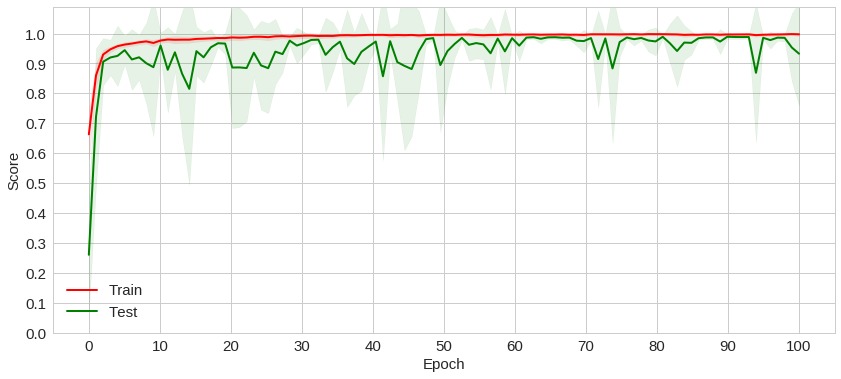

In [24]:
plot_mean_acc(hist)

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

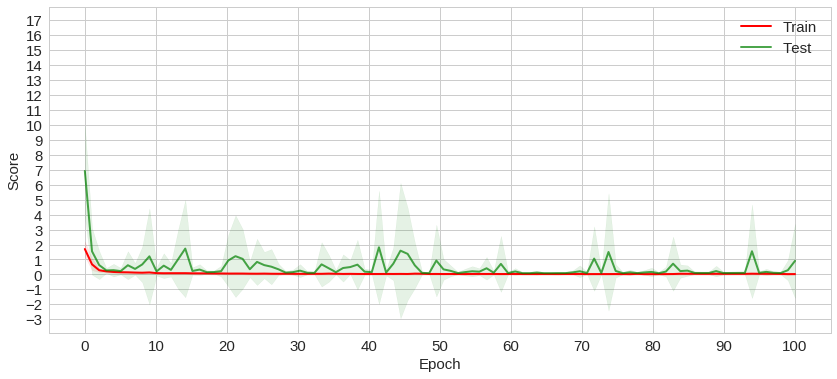

In [26]:
plot_mean_loss(hist)